# Library Import

In [1]:
#to display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#import scipy
import struct

from pathlib import Path
from sympy import divisors

from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats

from scipy.stats import bootstrap

from scipy.optimize import curve_fit #for the fit

# Input Reading

## reading

In [3]:
#dirName = '../mesons-master/build/dat/'
#name = 'odd_prova26.odd_df2_4fop'
dirName = '../../data_from_scp/'
#name = 'tm_mesons_run11.mesons'
#name = 'tm_mesons_run12.mesons'
#name = 'tm_mesons_run13.mesons'
#name = 'tm_mesons_run14.mesons'
#name = 'tm_mesons_run15.mesons'
#name = 'tm_mesons_run16.mesons'

#name = 'tm_mesons_run17.mesons'
#name = 'tm_mesons_run18.mesons' #equal to 17 but with swapped mus
#name = 'tm_mesons_run19.mesons' #equal to 17 but without isreal feature

name = 'tm_mesons_run20.mesons' #pi0 correlator is now right
name = 'tm_mesons_run21.mesons' #same as 20 but with the pi0 also with flavour swapped

name = 'tm_mesons_run23.mesons' #only quarks with +mu, pi+ with gamma5 and pi0 with identity

datName = name + '.dat'

fileName = dirName + datName

In [4]:
plot_base_dir = 'plots/'
plot_dir = 'plot_'+name.split('.')[0]
Path(plot_base_dir+plot_dir).mkdir(parents=True, exist_ok=True)

In [5]:
verbose=True #True to print more output

step = 1 #steps at which configurations are read

early_stop = 0 #number of configurations (counting from the end) not read

In [6]:
#the correlators array will be stored in a dict having as keys the configurations
conf_dict = {}

#list with configurations number
conf_num_list = []

##### reading data from binary dat file #####
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

    #header is made up of 4 integers, 4x4=16byte
    header_size= 4*4

    #first 16 byte are four 4-byte integers
    ncorr, nnoise, tvals, noise_type = struct.unpack("iiii", fileContent[:header_size])

    #initialization of correlators' variables
    k1=['']*ncorr
    k2=['']*ncorr
    
    mu1=['']*ncorr
    mu2=['']*ncorr

    type1=['']*ncorr
    type2=['']*ncorr
    
    x0=['']*ncorr
    isreal=['']*ncorr

    
    #each correlator has an header of size given by 4x8 + 4x4 = 48byte
    corr_header_size = 4*8 + 4*4
    
    #then there are ncorr block, 8x8 + 4x4 (8 double and 4 int) with the following structure 
    for i in range(ncorr):
         k1[i], k2[i], mu1[i], mu2[i], type1[i], type2[i], x0[i], isreal[i] = struct.unpack("ddddiiii",fileContent[header_size+corr_header_size*i:header_size+corr_header_size*(i+1)])



    #initialization of correlators array
    corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex) #correlators
    

    #configuration start right after the header
    first_conf = header_size+corr_header_size*ncorr
    
    #we compute the lenght of the data block for each configuration
    #          sizeof(int) (=confNumber)           ncorr * nnoise * tvals * 2 (re+im) * 8 (sizeof(double))
    conf_len = 4                                 +  nnoise * tvals * (2*ncorr - np.sum(isreal))         * 8         
    #the term with isreal is there because for real correlators only the real part gets stored

    #starting right after the header we read each configuration block
    for start_conf in range(first_conf, len(fileContent)-conf_len*early_stop, conf_len*step):
    #for start_conf in range(first_conf, len(fileContent)-conf_len, conf_len):

        #breaks loop if the file does not contain the whole correlator for the given configuration
        if start_conf+conf_len > len(fileContent) :
            break

        #reading of the configuration number
        conf_number = struct.unpack("i",fileContent[start_conf:start_conf+4])[0]
        if verbose==True:
            print(f"Reading: Gauge Conf = {conf_number}\n")

        #store of conf num
        if conf_number not in conf_num_list:
            conf_num_list.append(conf_number)

        #initialize to 0 the array storing the correlators
        corr.fill(complex(0,0))

        #initialize start reading
        start_reading = start_conf + 4

        #loop over the correlators (ncorr blocks of...)
        for ic in range(ncorr):
            
            #reading of 2 point functions
            for t in range(tvals):
                
                for inoise in range(nnoise):

                    if isreal[ic]==0:
                        #read re and im
                        re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                        #store them
                        corr[ic][t][inoise] = complex(re,im)
                        #update start reading
                        start_reading = start_reading+16

                    if isreal[ic]==1:
                        #read re
                        re = struct.unpack("d",fileContent[start_reading:start_reading+8])[0]
                        #store it
                        corr[ic][t][inoise] = complex(re,0.0)
                        #update start reading
                        start_reading = start_reading+8
                        
                    

        #store of correlators associated to the given configuration
        conf_dict[str(conf_number)] = corr.copy()

Reading: Gauge Conf = 1

Reading: Gauge Conf = 2

Reading: Gauge Conf = 3

Reading: Gauge Conf = 4

Reading: Gauge Conf = 5

Reading: Gauge Conf = 6

Reading: Gauge Conf = 7

Reading: Gauge Conf = 8

Reading: Gauge Conf = 9

Reading: Gauge Conf = 10

Reading: Gauge Conf = 11

Reading: Gauge Conf = 12

Reading: Gauge Conf = 13

Reading: Gauge Conf = 14

Reading: Gauge Conf = 15

Reading: Gauge Conf = 16

Reading: Gauge Conf = 17

Reading: Gauge Conf = 18

Reading: Gauge Conf = 19

Reading: Gauge Conf = 20

Reading: Gauge Conf = 21

Reading: Gauge Conf = 22

Reading: Gauge Conf = 23

Reading: Gauge Conf = 24

Reading: Gauge Conf = 25

Reading: Gauge Conf = 26

Reading: Gauge Conf = 27

Reading: Gauge Conf = 28

Reading: Gauge Conf = 29

Reading: Gauge Conf = 30

Reading: Gauge Conf = 31

Reading: Gauge Conf = 32

Reading: Gauge Conf = 33

Reading: Gauge Conf = 34

Reading: Gauge Conf = 35

Reading: Gauge Conf = 36

Reading: Gauge Conf = 37

Reading: Gauge Conf = 38

Reading: Gauge Conf =

In [7]:
ncorr_old = ncorr

In [8]:
#check on correct lenght calculations
(len(fileContent)-header_size-corr_header_size*ncorr)/conf_len

np.float64(200.0)

In [9]:
#construction of array with names and numbers of configurations
conf_names = list(conf_dict.keys())
conf_list = [int(conf) for conf in conf_names ]
nconf = len(conf_list)
nconf

200

In [10]:
#creation of a numpy array with all the correlators
correlators = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
for iconf,nameconf in enumerate(conf_names):
    correlators[iconf] = conf_dict[nameconf]

In [11]:
if verbose:
    print("(nconf, ncorrelators, tvals, nnoise)")
    print(np.shape(correlators))

(nconf, ncorrelators, tvals, nnoise)
(200, 14, 32, 100)


In [12]:
if verbose:
    for icorr in range(ncorr):
        print(f"k1  = {k1[icorr]}\n")
        print(f"k2  = {k2[icorr]}\n")
        print(f"mu1 = {mu1[icorr]}\n")
        print(f"mu2 = {mu2[icorr]}\n")
        print(f"G1  = {type1[icorr]}\n")
        print(f"G2  = {type2[icorr]}\n")
        print(f"x0  = {x0[icorr]}\n")
        print(f"isr = {isreal[icorr]}\n\n")

k1  = 0.135217

k2  = 0.135217

mu1 = 0.0113

mu2 = 0.0113

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0113

mu2 = 0.0113

G1  = 6

G2  = 6

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0151

mu2 = 0.0151

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0151

mu2 = 0.0151

G1  = 6

G2  = 6

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0302

mu2 = 0.0302

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0302

mu2 = 0.0302

G1  = 6

G2  = 6

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = 0.0454

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = 0.0454

G1  = 6

G2  = 6

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0605

mu2 = 0.0605

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0605

mu2 = 0.0605

G1  = 6

G2  = 6

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

In [86]:
#true_masses = np.asarray([0.2150,0.2449,0.3401,0.4182,0.4873])
true_masses = np.asarray([0.2150,0.2449,0.3401,0.4182,0.4873,0.5512,0.1811])
mus = np.array(mu1[::2])

#correction for swapped runs
#mus=np.abs(mus)
#mu1 = np.abs(mu1)

In [16]:
correlators.shape

(200, 14, 32, 100)

## cast to real and dim adjust

In [17]:
okks = correlators.mean(axis=-1).mean(axis=0)
#okks[::2,:]
np.mean(np.abs(okks[1::2,1:-1].imag/okks[1::2,1:-1].real))
np.std(np.abs(okks[1::2,1:-1].imag/okks[1::2,1:-1].real))

np.float64(0.6078321603186753)

np.float64(1.1085893783146825)

In [18]:
'''
#creation of a numpy array with all the correlators
correlators_old = np.empty(shape=(nconf,ncorr_old,tvals,nnoise),dtype=complex)
for iconf,nameconf in enumerate(conf_names):
    correlators_old[iconf] = conf_dict[nameconf]

ncorr = int(ncorr_old/3 * 2)

correlators = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)

for icorr in range(ncorr):
    if icorr%2==0:
        correlators[:,icorr] =  correlators_old[:,int(icorr*3/2)]
        print(f"{icorr} {int(icorr*3/2)}")
    else:
        correlators[:,icorr] = correlators_old[:,int(icorr*3/2)] + correlators_old[:,int(icorr*3/2)+1]
        print(f"{icorr} {int(icorr*3/2)} {int(icorr*3/2)+1}\n")



correlators = correlators.real
#correlators = np.abs(correlators)

#correlators[:,::2] = correlators[:,::2].real
#correlators[:,1::2] = correlators[:,1::2].imag
#correlators = correlators.real

if verbose:
    print("(nconf, ncorrelators, tvals, nnoise)")
    print(np.shape(correlators))
'''

'\n#creation of a numpy array with all the correlators\ncorrelators_old = np.empty(shape=(nconf,ncorr_old,tvals,nnoise),dtype=complex)\nfor iconf,nameconf in enumerate(conf_names):\n    correlators_old[iconf] = conf_dict[nameconf]\n\nncorr = int(ncorr_old/3 * 2)\n\ncorrelators = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)\n\nfor icorr in range(ncorr):\n    if icorr%2==0:\n        correlators[:,icorr] =  correlators_old[:,int(icorr*3/2)]\n        print(f"{icorr} {int(icorr*3/2)}")\n    else:\n        correlators[:,icorr] = correlators_old[:,int(icorr*3/2)] + correlators_old[:,int(icorr*3/2)+1]\n        print(f"{icorr} {int(icorr*3/2)} {int(icorr*3/2)+1}\n")\n\n\n\ncorrelators = correlators.real\n#correlators = np.abs(correlators)\n\n#correlators[:,::2] = correlators[:,::2].real\n#correlators[:,1::2] = correlators[:,1::2].imag\n#correlators = correlators.real\n\nif verbose:\n    print("(nconf, ncorrelators, tvals, nnoise)")\n    print(np.shape(correlators))\n'

In [25]:
correlators = correlators.real

## average over noise

In [26]:
corr_navg = correlators.mean(axis=-1)
if verbose:
    print("(nconf, ncorrelators, tvals)")
    print(np.shape(corr_navg))

(nconf, ncorrelators, tvals)
(200, 14, 32)


## preliminary plots

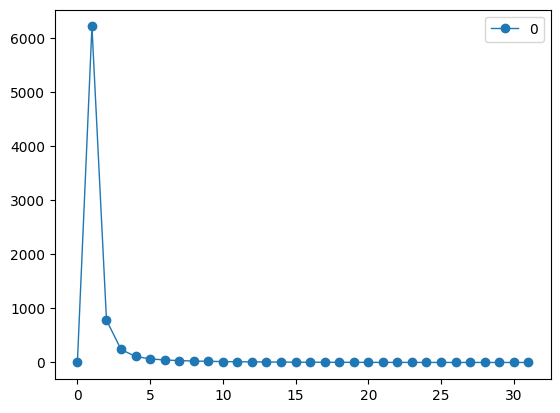

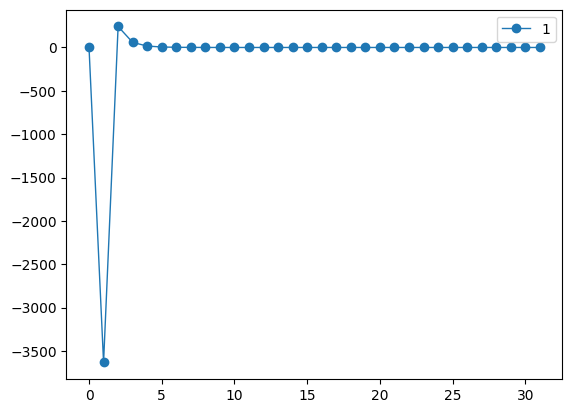

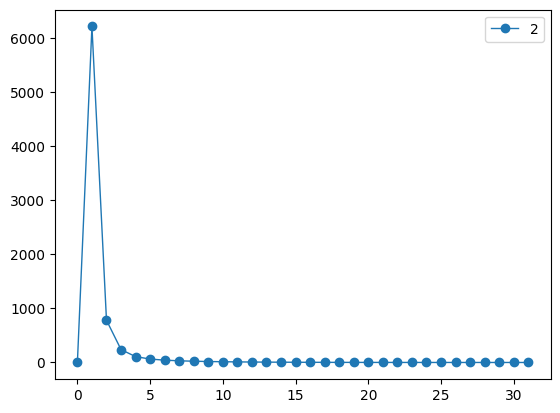

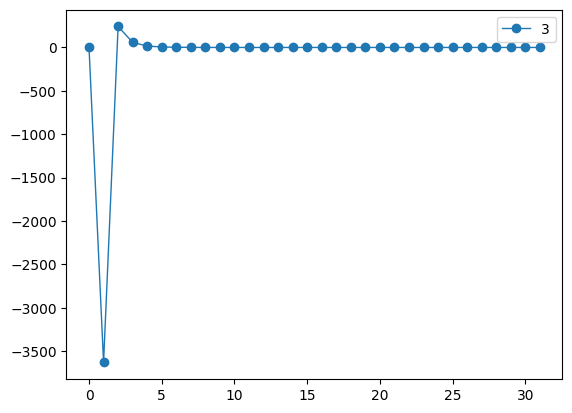

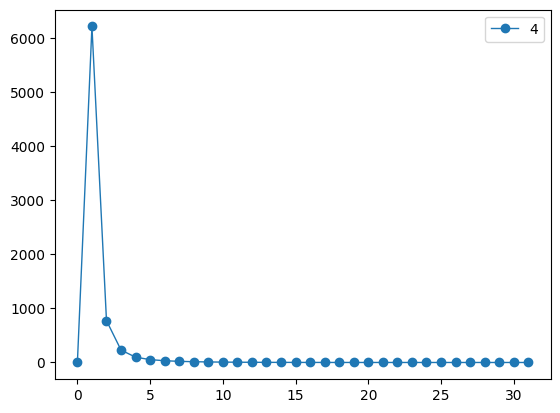

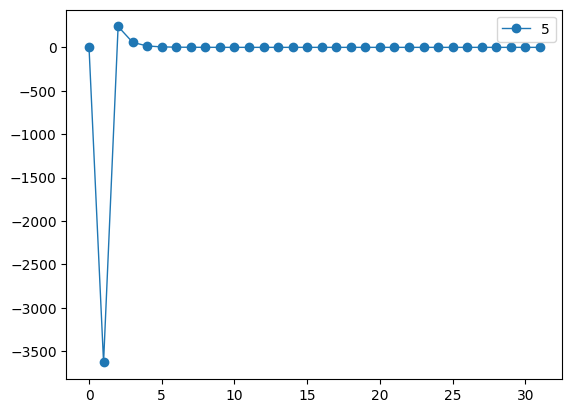

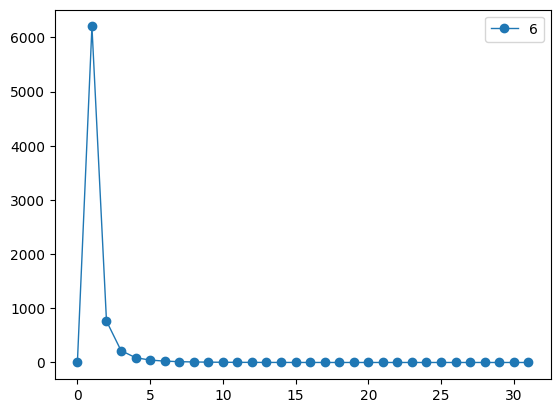

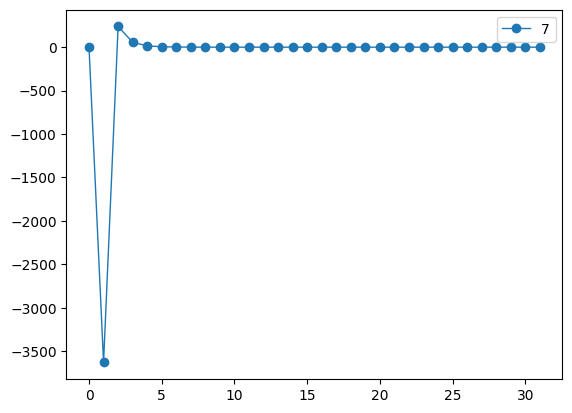

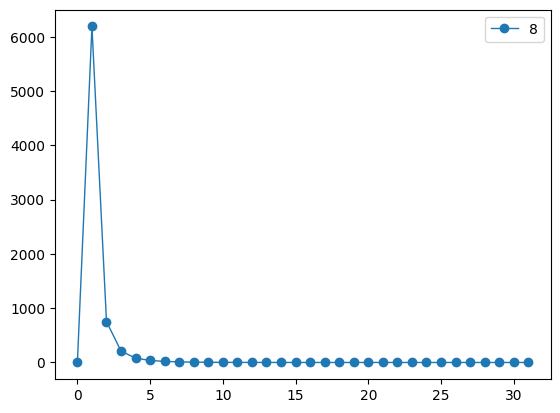

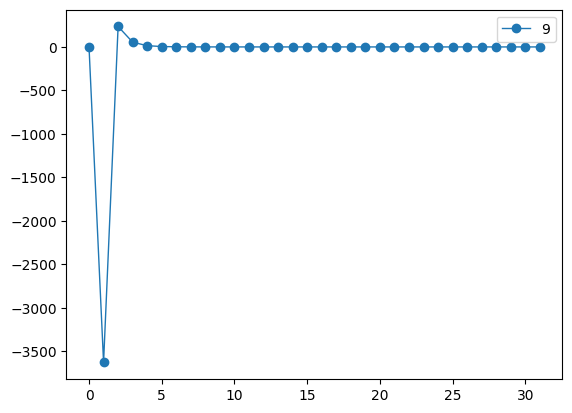

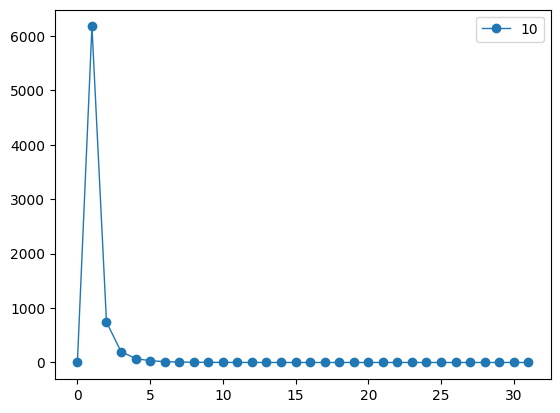

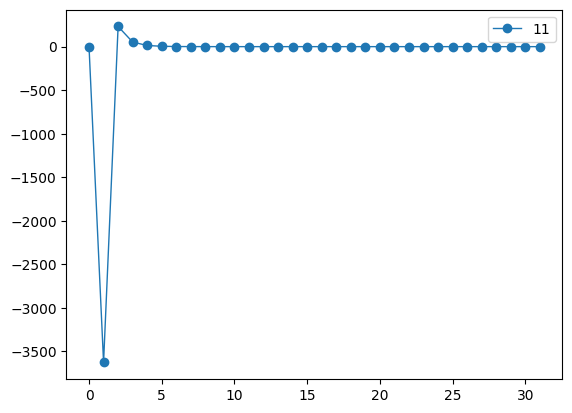

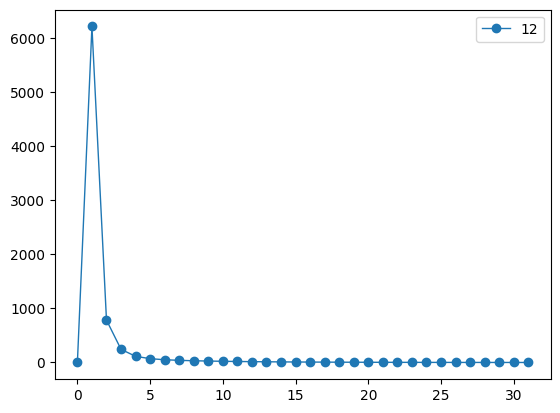

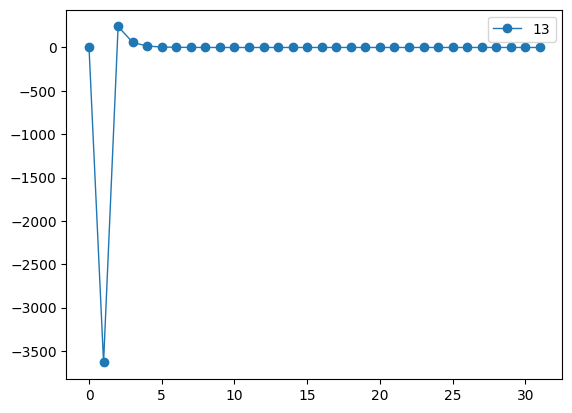

In [27]:
times = np.arange(tvals)

for ic in range(ncorr):
    _=plt.figure()
    _=plt.plot(times,np.mean(corr_navg[:,ic,:],axis=0), '-o',linewidth = 1,label=str(ic))
    _=plt.legend()

# Jacknife with effective and fit mass

In [28]:
def chi2(result,data,data_std):
    return np.sum( ((result-data)/data_std)**2 )/len(data_std)
    
def fit_sinh_x(t,amp,mass):
    T=tvals-1
    return amp*np.sinh(mass*(T-t)) #tvals-1 because T=tvals-1

def mass(corr_ratio,t,max_it=150,verb=False):

    eps=3e-7

    Time = tvals-1

    m0 = np.log(corr_ratio)

    massa = m0 #at iteration 0 the sinh is an exp and the mass is simply the log of the ration of correlators

    if corr_ratio <1.0:
        massa = 0
        return massa

    for it in range(max_it):


        '''
        if tvals-2*(t-1) -2 == 0 or tvals-2*(t-1) +2 ==0:
           break
        '''        
        

        #computes new mass from previous one
        
        #new_m = np.log(corr_ratio * (1-np.exp(-2*old_m*(tvals-t-1)))/(1-np.exp(-2*old_m*(tvals-t)) ) )

        den = 1 - np.exp( -2*massa * ( Time-t  ) )
        num = 1 - np.exp( -2*massa * ( Time-t-1) )
        #den = 1 + np.exp( -2*massa * ( Time-t  ) )
        #num = 1 + np.exp( -2*massa * ( Time-t-1) )
        

        new_massa = np.log( corr_ratio * num/den )

        if it%5 == 0 and verb==True:
            print(f"x t{t} it{it} delta = {np.abs((new_massa-massa)/massa)} \n")
        
        '''
        if np.abs(new_massa)>4.0 or new_massa<0:
            massa = 10
            break
        '''

        
        if np.abs(massa-new_massa)/massa < eps:
            massa=new_massa
            break
        

        massa = new_massa

    return massa

## Average over Noise

In [29]:
#it is already done above
if verbose:
    print("(nconf,ncorr,tvals)")
    print(np.shape(corr_navg))

(nconf,ncorr,tvals)
(200, 14, 32)


## Creation of jackknife Replicates

In [57]:
delta = 1 #binning of the jackknife procedure (we delete delta conf for each replicate

corr_navg_resamp = np.asarray( [np.delete(corr_navg, list(range(iconf,min(iconf+delta,nconf))) ,axis=0) for iconf in range(0,nconf,delta)] )

nresamples = int(nconf/delta)


if verbose:
    print("(nresamples,nconf-delta,ncorr,tvals)")
    print(np.shape(corr_navg_resamp))

(nresamples,nconf-delta,ncorr,tvals)
(200, 199, 14, 32)


## Correlator Identification

In [58]:
#first we take the correlator averaged over the gauge configurations (for each subsample)
corr_navg_resamp_gavg = corr_navg_resamp.mean(axis=1)

#this is the array with the replicates !!!
eff_mass_array = np.empty(shape=(ncorr,nresamples,tvals-1),dtype=float)
fit_mass_array = np.empty(shape=(ncorr,nresamples),dtype=float)
fit_amp_array = np.empty(shape=(ncorr,nresamples),dtype=float)

#chi2_array = np.empty(shape=(ncorr,nresamples),dtype=float)

chosen_maxit = 2000

#then we estimate the mass
for icorr in range(ncorr):


    #preparation for fit
    guess_mass=true_masses[int(icorr/2)]
    cut=8
    #cut=chosen_cuts[icorr]
    l_off=5
    r_off=0
    fit_times=times[cut+l_off:-cut-r_off]
    

    
    for ires in range(nresamples):
        
        for t in range(tvals-1):
            #insert here the formula for the mass:
            eff_mass_array[icorr,ires,t] = mass( corr_navg_resamp_gavg[ires,icorr,t] /  corr_navg_resamp_gavg[ires,icorr,t+1] , t,max_it=chosen_maxit)

        
        #mass from fit for each of the replicate
        guess_amp=corr_navg_resamp_gavg[ires,icorr,int(tvals/2)] / np.sinh( (tvals-1-tvals/2) * guess_mass )
        guess=[guess_amp,guess_mass]
        fit_data=corr_navg_resamp_gavg[ires,icorr,cut+l_off:-cut-r_off]
        popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, p0=guess,maxfev = 1300)
        perr_x = np.sqrt(np.diag(pcov_x))
        fit_mass_array[icorr,ires] = popt_x[1]
        fit_amp_array[icorr,ires] = popt_x[0]



#we then estimate the mass also on the whole dataset
corr_navg_gavg = corr_navg.mean(axis=0)

#this is the array with the mass computed on the whole dataset !!!
eff_mass_array_jacktotal = np.empty(shape=(ncorr,tvals-1),dtype=float)
fit_mass_array_jacktotal = np.empty(shape=(ncorr),dtype=float)
fit_amp_array_jacktotal = np.empty(shape=(ncorr),dtype=float)


for icorr in range(ncorr):

    #preparation for fit
    guess_mass=true_masses[int(icorr/2)]
    cut=8
    #cut=chosen_cuts[icorr]
    fit_times=times[cut+l_off:-cut-r_off]

    
    for t in range(tvals-1):
        eff_mass_array_jacktotal[icorr,t] = mass( corr_navg_gavg[icorr,t] / corr_navg_gavg[icorr,t+1] , t, verb=False, max_it=chosen_maxit)
        

    #mass from fit for each of the replicate
    guess_amp=corr_navg_gavg[icorr,int(tvals/2)] / np.sinh( (tvals-1-tvals/2) * guess_mass )
    guess=[guess_amp,guess_mass]
    fit_data=corr_navg_gavg[icorr,cut+l_off:-cut-r_off]
    popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, p0=guess,maxfev = 1200)
    perr_x = np.sqrt(np.diag(pcov_x))
    fit_mass_array_jacktotal[icorr] = popt_x[1]
    fit_amp_array_jacktotal[icorr] = popt_x[0]




if verbose:
    print("(nresamples,ncorr,tvals)")
    print(np.shape(corr_navg_resamp_gavg))
    
    print("(ncorr,tvals)")
    print(np.shape(corr_navg_gavg))

/tmp/ipykernel_446088/2291156380.py:14: RuntimeWarning: divide by zero encountered in log
  m0 = np.log(corr_ratio)
/tmp/ipykernel_446088/2097304784.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  eff_mass_array[icorr,ires,t] = mass( corr_navg_resamp_gavg[ires,icorr,t] /  corr_navg_resamp_gavg[ires,icorr,t+1] , t,max_it=chosen_maxit)
/tmp/ipykernel_446088/2291156380.py:36: RuntimeWarning: invalid value encountered in scalar multiply
  num = 1 - np.exp( -2*massa * ( Time-t-1) )
/tmp/ipykernel_446088/2291156380.py:14: RuntimeWarning: invalid value encountered in log
  m0 = np.log(corr_ratio)


(nresamples,ncorr,tvals)
(200, 14, 32)
(ncorr,tvals)
(14, 32)


/tmp/ipykernel_446088/2097304784.py:64: RuntimeWarning: divide by zero encountered in scalar divide
  eff_mass_array_jacktotal[icorr,t] = mass( corr_navg_gavg[icorr,t] / corr_navg_gavg[icorr,t+1] , t, verb=False, max_it=chosen_maxit)


In [59]:
#the estimate is the mean of the replicates
eff_estimate = np.mean(eff_mass_array,axis=1) #(the replicate axis)
#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
eff_bias = (nresamples-1) * (eff_estimate-eff_mass_array_jacktotal)
#the std is given by the following formula (variance of replicates times n-1)
eff_std = np.array( [np.sqrt( (nresamples-1)/nresamples * np.sum( (eff_mass_array[icorr] - eff_estimate[icorr])**2,axis=0 ) ) for icorr in range(ncorr)]   ) 
#then we correct the estimate for the bias
eff_estimate_biascorr = eff_estimate-eff_bias

if verbose:
    print("(ncorr,tvals)")
    print(np.shape(eff_estimate_biascorr))
    print(np.shape(eff_std))


#the estimate is the mean of the replicates
fit_estimate = np.mean(fit_mass_array,axis=1) #(the replicate axis)
#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
fit_bias = (nresamples-1) * (fit_estimate-fit_mass_array_jacktotal)
#the std is given by the following formula (variance of replicates times n-1)
fit_std = np.array( [np.sqrt( (nresamples-1)/nresamples * np.sum( (fit_mass_array[icorr] - fit_estimate[icorr])**2,axis=0 ) ) for icorr in range(ncorr)]   ) 
#then we correct the estimate for the bias
fit_estimate_biascorr = fit_estimate-fit_bias

if verbose:
    print("(ncorr)")
    print(np.shape(fit_estimate_biascorr))
    print(np.shape(fit_std))


#the estimate is the mean of the replicates
amp_fit_estimate = np.mean(fit_amp_array,axis=1) #(the replicate axis)
#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
amp_fit_bias = (nresamples-1) * (amp_fit_estimate-fit_amp_array_jacktotal)
#the std is given by the following formula (variance of replicates times n-1)
amp_fit_std = np.array( [np.sqrt( (nresamples-1)/nresamples * np.sum( (fit_amp_array[icorr] - amp_fit_estimate[icorr])**2,axis=0 ) ) for icorr in range(ncorr)]   ) 
#then we correct the estimate for the bias
amp_fit_estimate_biascorr = amp_fit_estimate-amp_fit_bias

if verbose:
    print("(ncorr)")
    print(np.shape(fit_estimate_biascorr))
    print(np.shape(fit_std))

(ncorr,tvals)
(14, 31)
(14, 31)
(ncorr)
(14,)
(14,)
(ncorr)
(14,)
(14,)


In [60]:
M_fit = fit_estimate_biascorr
M_fit_std = fit_std

amp_fit = amp_fit_estimate_biascorr
amp_fit_std = amp_fit_std

In [61]:
cut = 6

#left_cut=16
#right_cut=8
left_cut=cut
right_cut=cut#+5

In [74]:
for icc in range(ncorr):
    #np.where( eff_estimate_biascorr[icc,:] > 10*np.abs( eff_estimate_biascorr[icc,int(tvals/2)] ) )
    eff_estimate_biascorr[icc,:][ eff_estimate_biascorr[icc,:] > 10*np.abs( eff_estimate_biascorr[icc,int(tvals/2)] ) ] = 0

In [75]:
for icc in range(ncorr):
    #np.where( eff_std[icc,:] > 2*np.mean(eff_std[icc,:]) )
    eff_estimate_biascorr[icc,:][eff_std[icc,:] > 2*np.mean(eff_std[icc,:])] = np.mean(eff_estimate_biascorr[icc,:])
    eff_estimate_biascorr[icc,:]

array([ 0.        ,  2.07208882,  1.17792443,  0.77346992,  0.50890111,
        0.36324506,  0.29180292,  0.25122622,  0.23582871,  0.22363031,
        0.21780658,  0.21295561,  0.21219991,  0.21461373,  0.21109747,
        0.20486398,  0.21226433,  0.20974809,  0.20574265,  0.20779911,
        0.20779592,  0.2042857 ,  0.20530614,  0.21010272,  0.21533085,
        0.21059499,  0.17161152,  0.01433705, -0.18996889, -0.27136933,
               nan])

array([0.        , 0.        , 1.42249059, 1.27458605, 1.08879692,
       0.99059954, 0.98140846, 1.20539717, 0.47469013, 0.        ,
       0.        , 0.75695921, 0.23643946, 0.29534035, 0.3664117 ,
       0.34206045, 0.27267429, 0.24415397, 0.        , 0.48503649,
       0.23466128, 0.25162545, 0.29414626, 0.30594606, 0.27801457,
       0.32296069, 0.41978317, 0.5576792 , 0.96620376, 1.122019  ,
       0.        ])

array([ 0.        ,  2.0738358 ,  1.18509129,  0.78961537,  0.53349391,
        0.39373019,  0.32575918,  0.28618623,  0.26975588,  0.25696675,
        0.24953291,  0.24484746,  0.24456136,  0.24651662,  0.243275  ,
        0.23768445,  0.24393798,  0.24024296,  0.23569727,  0.23671147,
        0.23673333,  0.23463615,  0.23426163,  0.23516056,  0.23534121,
        0.2255865 ,  0.18405543, -0.68932176, -0.17948773, -0.26696028,
               nan])

array([0.        , 0.        , 1.42295713, 1.27279878, 1.08006446,
       0.96455855, 0.91227096, 0.9981765 , 1.16660154, 0.50992375,
       0.        , 0.        , 0.21561883, 0.27708002, 0.34127914,
       0.31407335, 0.27978429, 0.27959739, 0.1370021 , 1.32611596,
       0.22049106, 0.23976945, 0.30432995, 0.3799663 , 0.32985128,
       0.35968911, 0.41959496, 0.53287523, 0.93010568, 1.10298433,
       0.        ])

array([ 0.        ,  2.08245702,  1.21552701,  0.85016218,  0.61760197,
        0.49103094,  0.42917475,  0.39153491,  0.37295419,  0.35889787,
        0.34879639,  0.3441767 ,  0.34410976,  0.3449995 ,  0.34245084,
        0.33866316,  0.34389687,  0.33941688,  0.33421974,  0.33480209,
        0.33438956,  0.3333116 ,  0.33264828,  0.32999359,  0.3243664 ,
        0.30952427,  0.27004211,  0.15053731, -0.14186787, -0.21471827,
               nan])

array([ 0.        ,  0.        ,  1.43059003,  1.28082029,  1.08193945,
        0.94868032,  0.85753587,  0.83364096,  0.81656888,  0.8124443 ,
        0.76521796,  0.8052716 ,  0.74222687,  0.59266909, -0.28852194,
        1.11683241,  1.11683241,  1.11683241,  0.        ,  0.        ,
        0.12033562,  2.55288388,  0.31904324,  0.4566007 ,  0.43299902,
        0.47741291,  0.47237688,  0.54249083,  0.91056192,  1.12606656,
        0.        ])

array([ 0.        ,  2.09306821,  1.2477895 ,  0.90697547,  0.69038206,
        0.57093323,  0.51125175,  0.47432857,  0.45471831,  0.43990885,
        0.42908558,  0.42424049,  0.42354427,  0.42393963,  0.42146607,
        0.41816881,  0.42291416,  0.41914848,  0.41400445,  0.41491726,
        0.41476341,  0.41338035,  0.41376161,  0.4114934 ,  0.40685691,
        0.39386738,  0.35991046,  0.276811  , -0.04509667, -0.13048855,
               nan])

array([0.        , 0.        , 1.44458938, 1.30196197, 1.10806137,
       0.97650819, 0.88348006, 0.84276629, 0.81093137, 0.79100901,
       0.75648285, 0.76532757, 0.76267802, 0.78184238, 0.78644345,
       0.71602618, 0.55955043, 0.5332849 , 0.5332849 , 0.        ,
       0.        , 0.        , 0.34565374, 0.4642374 , 0.4700467 ,
       0.54189229, 0.57843308, 0.53823846, 0.5332849 , 0.5332849 ,
       0.        ])

array([ 0.        ,  2.1048759 ,  1.28037425,  0.96022869,  0.75569646,
        0.64105347,  0.58246213,  0.54588903,  0.52567033,  0.5104125 ,
        0.49938446,  0.4943719 ,  0.49305306,  0.49316024,  0.49064492,
        0.48735989,  0.49147427,  0.48850476,  0.48361472,  0.48452086,
        0.4848092 ,  0.48327237,  0.48430973,  0.48253247,  0.47962549,
        0.46964259,  0.44117305,  0.37574814,  0.1618662 , -0.13066065,
               nan])

array([0.        , 0.        , 1.46246703, 1.32922944, 1.14256488,
       1.01539735, 0.9247958 , 0.87935936, 0.84499358, 0.82303803,
       0.79600387, 0.79753437, 0.80094337, 0.8147281 , 0.84240016,
       0.83529172, 0.80062178, 0.70006783, 0.61621066, 0.48952639,
       0.        , 0.        , 0.39430029, 0.458551  , 0.48665385,
       0.56834   , 0.64670249, 0.59687316, 0.70468218, 0.48952639,
       0.        ])

array([ 0.        ,  2.11755551,  1.31302075,  1.01097342,  0.81631163,
        0.70536979,  0.64748211,  0.61115   ,  0.59051946,  0.575007  ,
        0.56392919,  0.55878447,  0.55694555,  0.55683571,  0.5543163 ,
        0.55092572,  0.55444078,  0.5521609 ,  0.5475703 ,  0.54827437,
        0.54888487,  0.54733717,  0.54867437,  0.54716284,  0.54562721,
        0.53844105,  0.51495095,  0.46143733,  0.30726087, -0.4725066 ,
               nan])

array([0.        , 0.        , 1.48302016, 1.35992904, 1.1807436 ,
       1.05809886, 0.97045723, 0.92349855, 0.88893332, 0.86675846,
       0.84362887, 0.84246235, 0.8461096 , 0.85160784, 0.87742146,
       0.87844051, 0.88464257, 0.83189748, 0.83981332, 0.73529097,
       0.91334443, 0.        , 1.1414923 , 0.50690222, 0.51952023,
       0.58355925, 0.66216445, 0.64604926, 0.54527256, 0.91334443,
       0.        ])

array([ 0.        ,  0.        ,  1.17104957,  0.75675271,  0.48173494,
        0.32778903,  0.25102133,  0.20888157,  0.19512744,  0.18389331,
        0.18066367,  0.17588263,  0.17463595,  0.1778392 ,  0.17401222,
        0.1672076 ,  0.17676306,  0.17672451,  0.17418434,  0.17848819,
        0.17778691,  0.17158788,  0.17564007,  0.18794254,  0.20102131,
        0.20462679,  0.17103701,  0.2996881 , -0.1849956 , -0.26985884,
               nan])

array([ 0.        ,  0.        ,  1.42279652,  1.27877918,  1.10504653,
        1.04057303,  1.13770179,  0.45945165,  0.        ,  0.        ,
        0.15923345,  0.15897331,  0.24439507,  0.28853025,  0.35660576,
        0.33173147,  0.26915489,  0.2165335 , -0.59654525,  0.20052306,
        0.26166742,  0.23508811,  0.13477959,  0.45945165,  0.45945165,
        0.44773514,  0.45945165,  0.60579459,  0.45945165,  1.03461123,
        0.        ])

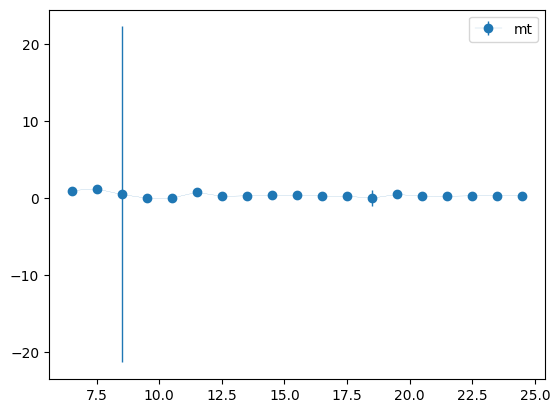

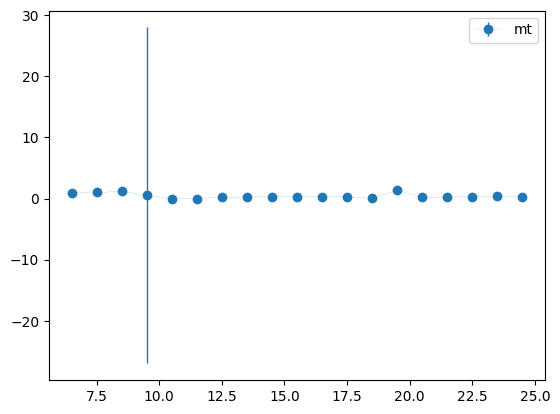

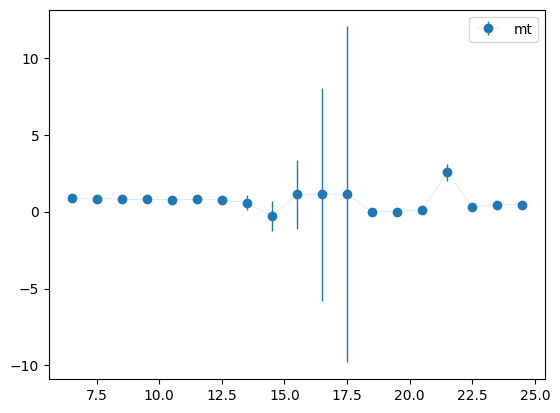

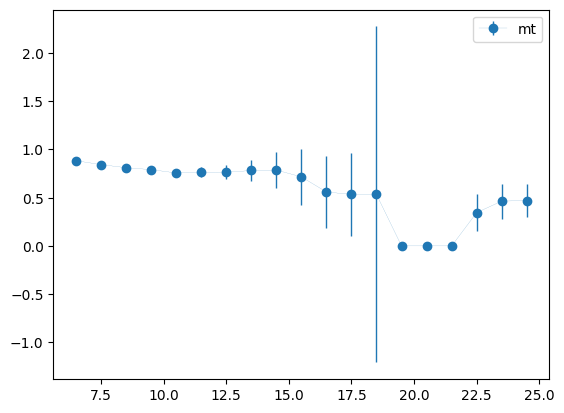

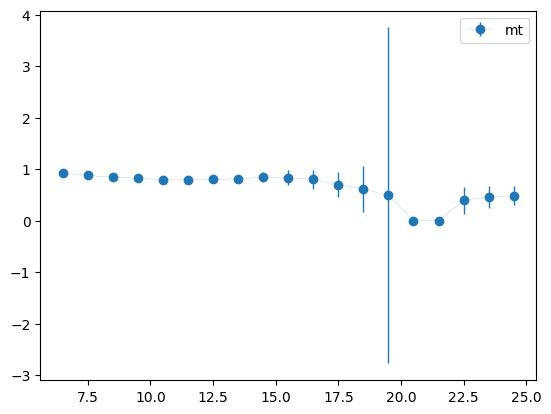

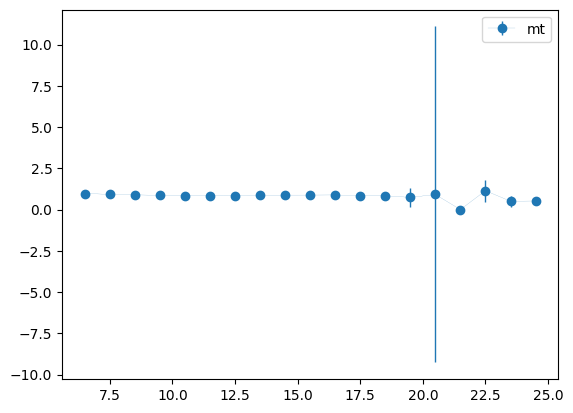

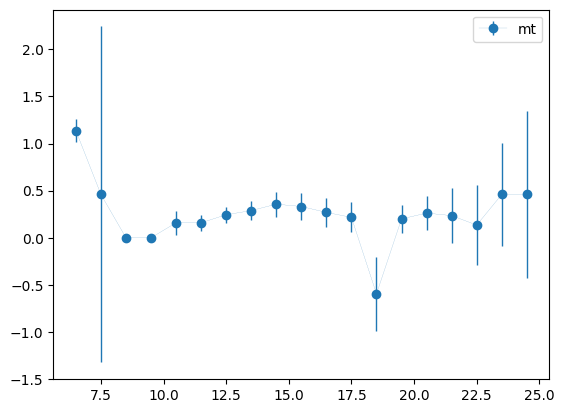

In [76]:
#check on correctness of plateau
#eff_estimate_biascorr[1::2,cut:-cut]

mass_times = times[left_cut:-right_cut-1]+0.5

for icorr in range(0,ncorr,2):
    _=plt.figure()
    #_=plt.errorbar(mass_times,eff_estimate_biascorr[icorr,left_cut:-right_cut],yerr=eff_std[icorr,left_cut:-right_cut],marker='o',linewidth=0.1,elinewidth=1.0,label='m')
    _=plt.errorbar(mass_times,eff_estimate_biascorr[icorr+1,left_cut:-right_cut],yerr=eff_std[icorr+1,left_cut:-right_cut],marker='o',linewidth=0.1,elinewidth=1.0,label='mt')
    _=plt.legend()

In [79]:
sqM_fit = fit_estimate_biascorr**2
sqM_fit_std = 2*np.abs(fit_estimate_biascorr)*fit_std

M_eff = np.empty(shape=(ncorr),dtype=float)
M_eff_std = np.empty(shape=(ncorr),dtype=float)
chosen_cuts = np.empty(shape=(ncorr),dtype=int)

max_chi2 = 1.5

l_off = 5
r_off = 0

#plateau determination for each correlator
for icorr in range(ncorr):

    chosen_cut = int(tvals/2)-1
    chosen_cut = 8
    chosen_cuts[icorr]=chosen_cut
    
    for icut in range(3,int(tvals/2)):
        imeff = np.mean(eff_estimate_biascorr[icorr,icut+l_off:-icut-r_off])
        if chi2(imeff,eff_estimate_biascorr[icorr,icut+l_off:-icut-r_off],eff_std[icorr,icut+l_off:-icut-r_off])  < max_chi2:
            chosen_cut = icut
            chosen_cuts[icorr]=chosen_cut
            print(f"icorr{icorr}  cut{chosen_cut}")
            break
         
    
    M_eff[icorr] = np.mean(eff_estimate_biascorr[icorr,chosen_cut+l_off:-chosen_cut-r_off])
    M_eff_std[icorr] = np.sqrt( np.mean( eff_std[icorr,chosen_cut+l_off:-chosen_cut-r_off]**2 ) )

#M_eff = np.mean(eff_estimate_biascorr[:,left_cut:-right_cut],axis=1)
#M_eff_std = np.sqrt( np.mean( eff_std[:,left_cut:-right_cut]**2 ,axis=1 ) )
sqM_eff = M_eff**2
sqM_eff_std = 2*np.abs(M_eff)*M_eff_std

sqM_true = true_masses**2

icorr0  cut4
icorr1  cut6
icorr2  cut5
icorr3  cut7
icorr4  cut8
icorr6  cut8
icorr7  cut12
icorr8  cut9
icorr9  cut11
icorr10  cut9
icorr11  cut10
icorr12  cut4
icorr13  cut5


/tmp/ipykernel_446088/2291156380.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sum( ((result-data)/data_std)**2 )/len(data_std)
/tmp/ipykernel_446088/2291156380.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum( ((result-data)/data_std)**2 )/len(data_std)


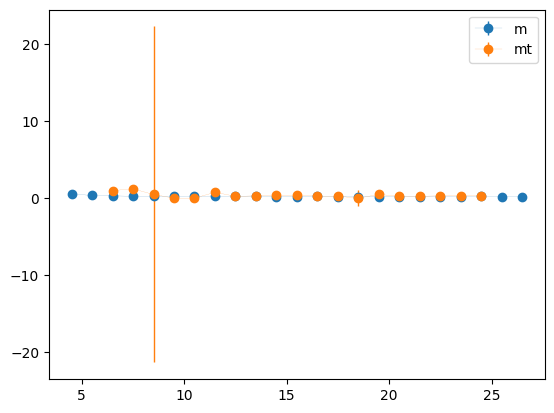

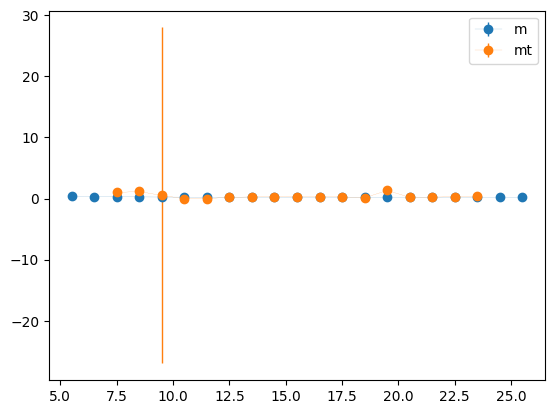

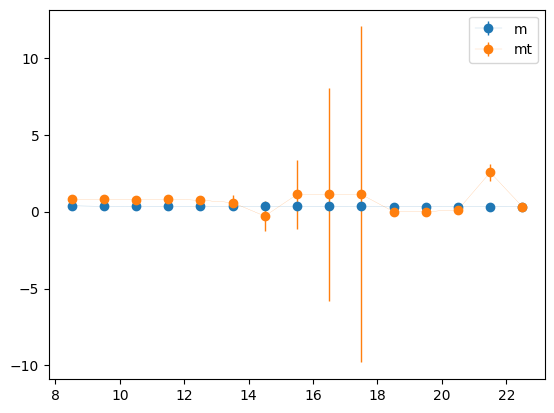

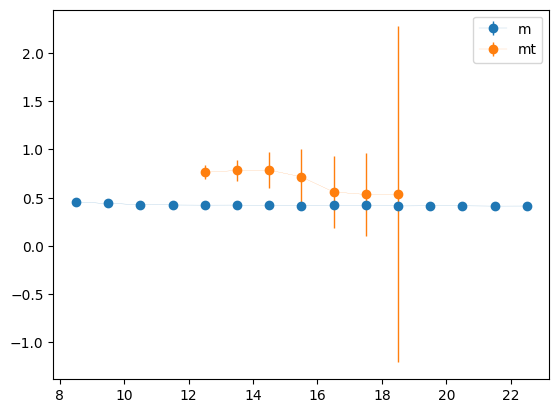

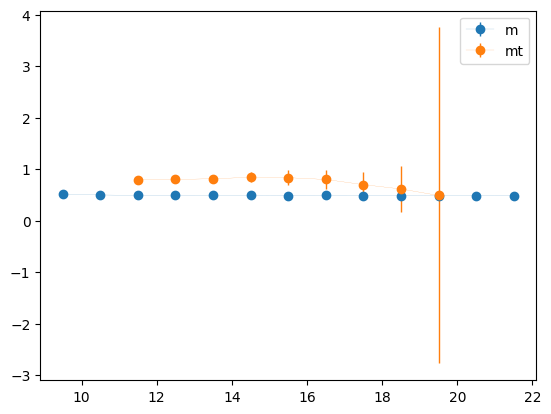

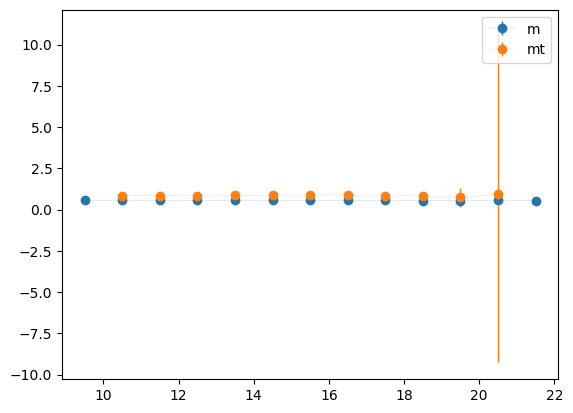

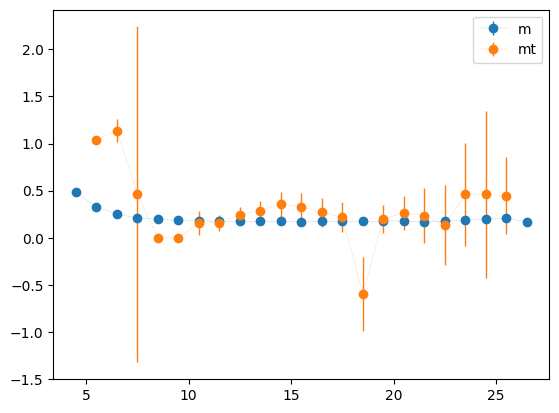

In [80]:

for icorr in range(0,ncorr,2):
    _=plt.figure()
    cut_m=chosen_cuts[icorr]
    mass_times = times[cut_m:-cut_m-1]+0.5
    _=plt.errorbar(mass_times,eff_estimate_biascorr[icorr,cut_m:-cut_m],yerr=eff_std[icorr,cut_m:-cut_m],marker='o',linewidth=0.1,elinewidth=1.0,label='m')
    cut_mt=chosen_cuts[icorr+1]
    mass_times = times[cut_mt:-cut_mt-1]+0.5
    _=plt.errorbar(mass_times,eff_estimate_biascorr[icorr+1,cut_mt:-cut_mt],yerr=eff_std[icorr+1,cut_mt:-cut_mt],marker='o',linewidth=0.1,elinewidth=1.0,label='mt')
    _=plt.legend()

In [81]:
#M-Mtilda division

M2_fit = sqM_fit[::2]
M2_fit_std = sqM_fit_std[::2]

M2t_fit = sqM_fit[1::2]
M2t_fit_std = sqM_fit_std[1::2]


M2_eff = sqM_eff[::2]
M2_eff_std = sqM_eff_std[::2]

M2t_eff = sqM_eff[1::2]
M2t_eff_std = sqM_eff_std[1::2]

In [87]:
def fit_lin(x,m,q):
    return m * x + q

#mu_range = np.linspace(0,np.max(mu1)*1.1,100)
mu_range = np.linspace(0,np.max(mu1)*1.1,100)


guess_par = [ ( M2_fit[-1]-M2_fit[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, M2_fit, sigma= M2_fit_std, p0=guess_par)
M2_fit_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nM2 fit")
print(popt)
print(np.sqrt(np.diag(pcov)))

guess_par = [ ( M2t_fit[-1]-M2t_fit[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, M2t_fit, sigma= M2t_fit_std, p0=guess_par)
M2t_fit_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nM2t fit")
print(popt)
print(np.sqrt(np.diag(pcov)))

guess_par = [ ( M2_eff[-1]-M2_eff[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, M2_eff, sigma= M2_eff_std, p0=guess_par)
M2_eff_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nM2 eff")
print(popt)
print(np.sqrt(np.diag(pcov)))

guess_par = [ ( M2t_eff[-1]-M2t_eff[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, M2t_eff, sigma= M2t_eff_std, p0=guess_par)
M2t_eff_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nM2t eff")
print(popt)
print(np.sqrt(np.diag(pcov)))


guess_par = [ ( sqM_true[-1]-sqM_true[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, sqM_true, p0=guess_par)
fit_reference = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nM2 true")
print(popt)
print(np.sqrt(np.diag(pcov)))


M2 fit
[ 4.04711985e+00 -2.59576714e-03]
[0.0472681  0.00181155]

M2t fit
[10.5364832  -0.02693681]
[0.78406128 0.02850191]

M2 eff
[ 3.98831365e+00 -2.78944131e-03]
[0.05856619 0.00259829]

M2t eff
[ 8.33334384e+00 -3.70178448e-03]
[1.04383643 0.01293742]

M2 true
[ 3.95565539e+00 -1.52047020e-04]
[0.05914152 0.00252526]


In [101]:
def do_my_plot(fit=True,eff=True,truem=True,dirfit=False,save=False,diff=False):

    _=plt.figure(dpi=1200)

    if fit:
        _=plt.errorbar(mus,M2_fit,M2_fit_std,marker='o',linewidth=0,elinewidth=1.0,label=r"$m_{PS}^2$ (from sinh fit)",color='limegreen',alpha=0.6)
        _=plt.plot(mu_range,M2_fit_linfit,linewidth =0.7,linestyle='dashed',color='limegreen',alpha=0.6)
        _=plt.errorbar(mus,M2t_fit,M2t_fit_std,marker='s',linewidth=0,elinewidth=1.0,label=r"$\widetilde{m_{PS}^2}$ (from sinh fit)",color='darkgreen',alpha=0.6)
        _=plt.plot(mu_range,M2t_fit_linfit,linewidth =0.7,linestyle='dashed',color='darkgreen',alpha=0.6)

    if eff:
        #_=plt.errorbar(mus,M2_eff,M2_eff_std,marker='o',linewidth=0,elinewidth=1.0,label=r"$m_{PS}^2$ (effective mass)",color='royalblue',alpha=0.6)
        _=plt.plot(mus,M2_eff,marker='o',linewidth=0,label=r"$m_{PS}^2$ (effective mass)",color='royalblue',alpha=0.6)
        _=plt.plot(mu_range,M2_eff_linfit,linewidth =0.7,linestyle='dashed',color='royalblue',alpha=0.6)
        #_=plt.errorbar(mus,M2t_eff,M2t_eff_std,marker='s',linewidth=0,elinewidth=1.0,label=r"$\widetilde{m_{PS}^2}$ (effective mass)",color='darkblue',alpha=0.6)
        _=plt.plot(mus,M2t_eff,marker='s',linewidth=0,label=r"$\widetilde{m_{PS}^2}$ (effective mass)",color='darkblue',alpha=0.6)
        _=plt.plot(mu_range,M2t_eff_linfit,linewidth =0.7,linestyle='dashed',color='blue',alpha=0.6)
    
    
    if truem:
        _=plt.plot(mus,sqM_true,marker='o',linewidth=0,label=r"$M_P$ from reference",color='red',alpha=0.6)
        _=plt.plot(mu_range,fit_reference,linewidth =0.7,linestyle='dashed',color='red',alpha=0.6)


    #_=plt.plot(mus,mass_directfit[::2]**2,'^',label='m direct',linewidth =1,alpha=0.6,color='purple')
    #_=plt.plot(mus,mass_directfit[1::2]**2,'v',label='mt direct',linewidth =1,alpha=0.6,color='brown')

    if dirfit:
        _=plt.errorbar(mus,m2_dirfit,yerr=m2_sig_dirfit,marker='^',linewidth=0,label=r"m dirfit",color='purple',alpha=0.6)
        _=plt.errorbar(mus,m2t_dirfit,yerr=m2t_sig_dirfit,marker='v',linewidth=0,label=r"mt dirfit",color='brown',alpha=0.6)

    if diff:
        _=plt.plot(mus,(np.sqrt(M2t_eff)-np.sqrt(M2_eff))/np.sqrt(M2_eff),marker='o',linewidth=0,label=r"mass diff",color='royalblue',alpha=0.6)
        _=plt.yscale('log')

        
    
    #_=plt.errorbar(mus,excM2[::2],excM2_std[::2],marker='^',linewidth=0,elinewidth=1.0,label=r"excM2",color='purple',alpha=0.6)
    #_=plt.errorbar(mus,excM2[1::2],excM2_std[1::2],marker='v',linewidth=0,elinewidth=1.0,label=r"excM2_t",color='magenta',alpha=0.6)
    
    #_=plt.xlim((0,np.max(mu1)*1.1))
    _=plt.xlim((0,np.max(mu1)*1.1))
    
    _=plt.xlabel(r"$\mu$")
    
    
    _=plt.legend()


    _=plt.grid()

    
    _=plt.title(r"$m^2$ vs $\mu$")
    _=plt.ylabel(r"$m^2$")
    _=plt.tight_layout()

    if save != False:
        plt.savefig(save)

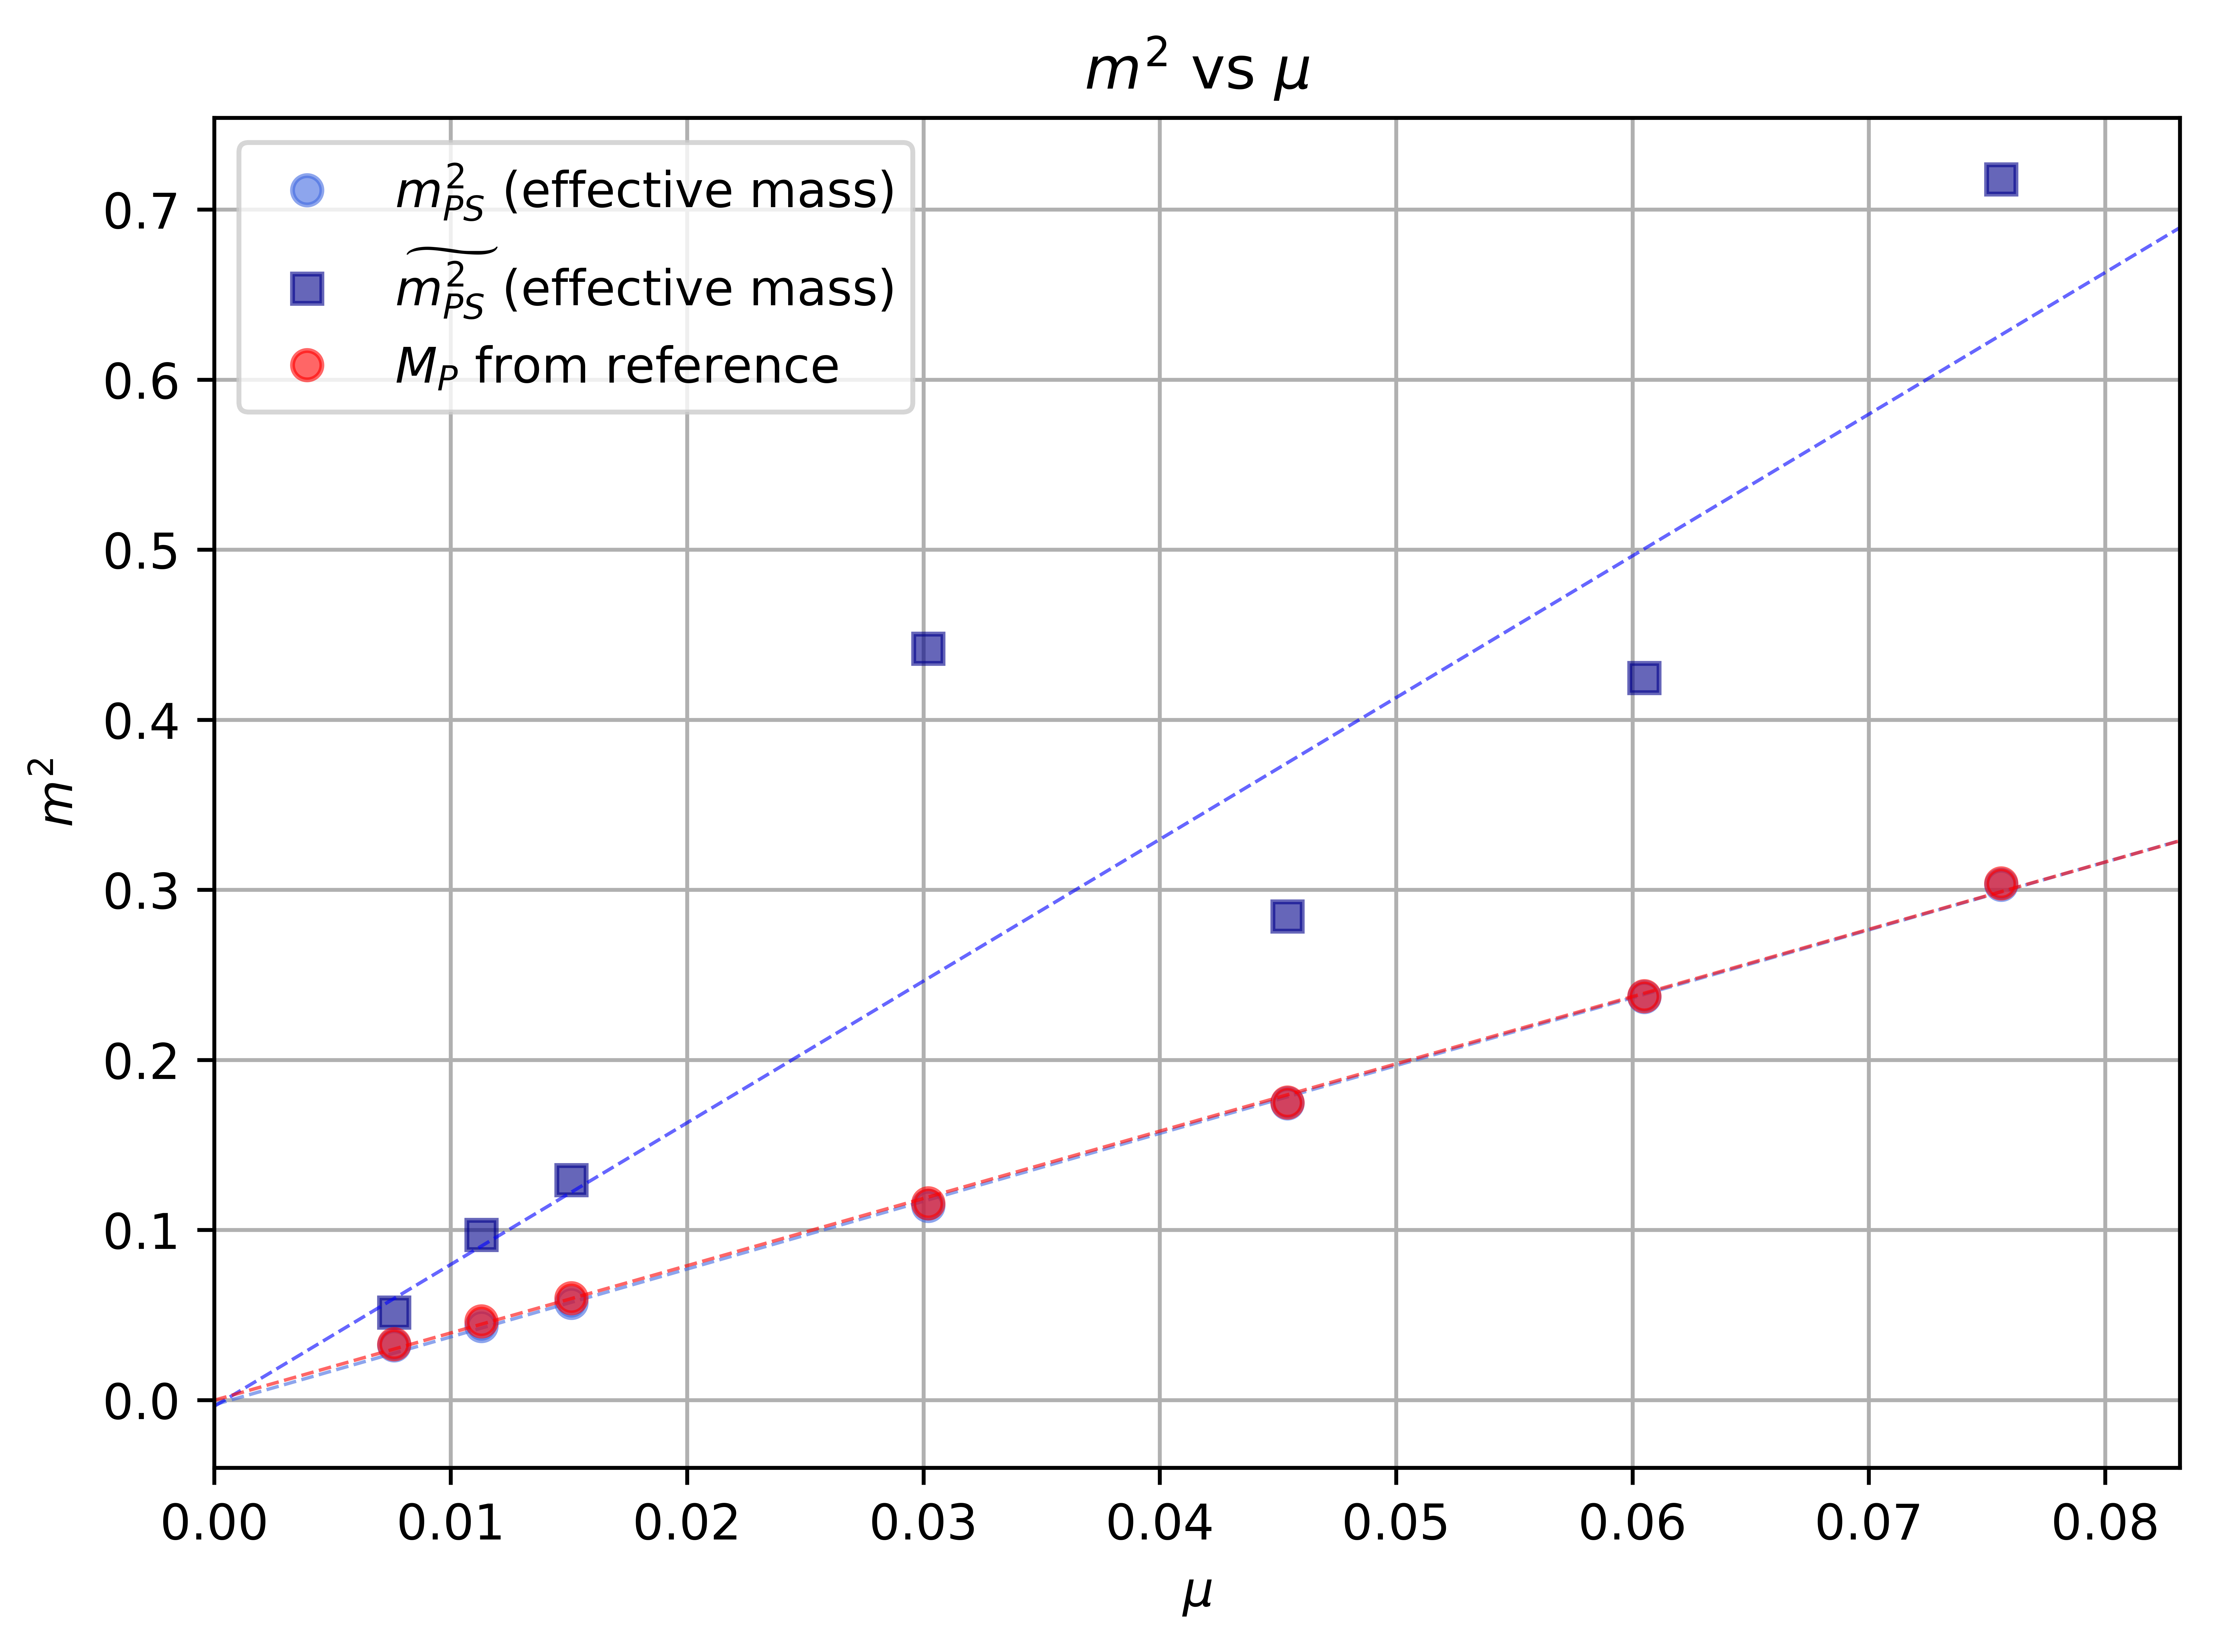

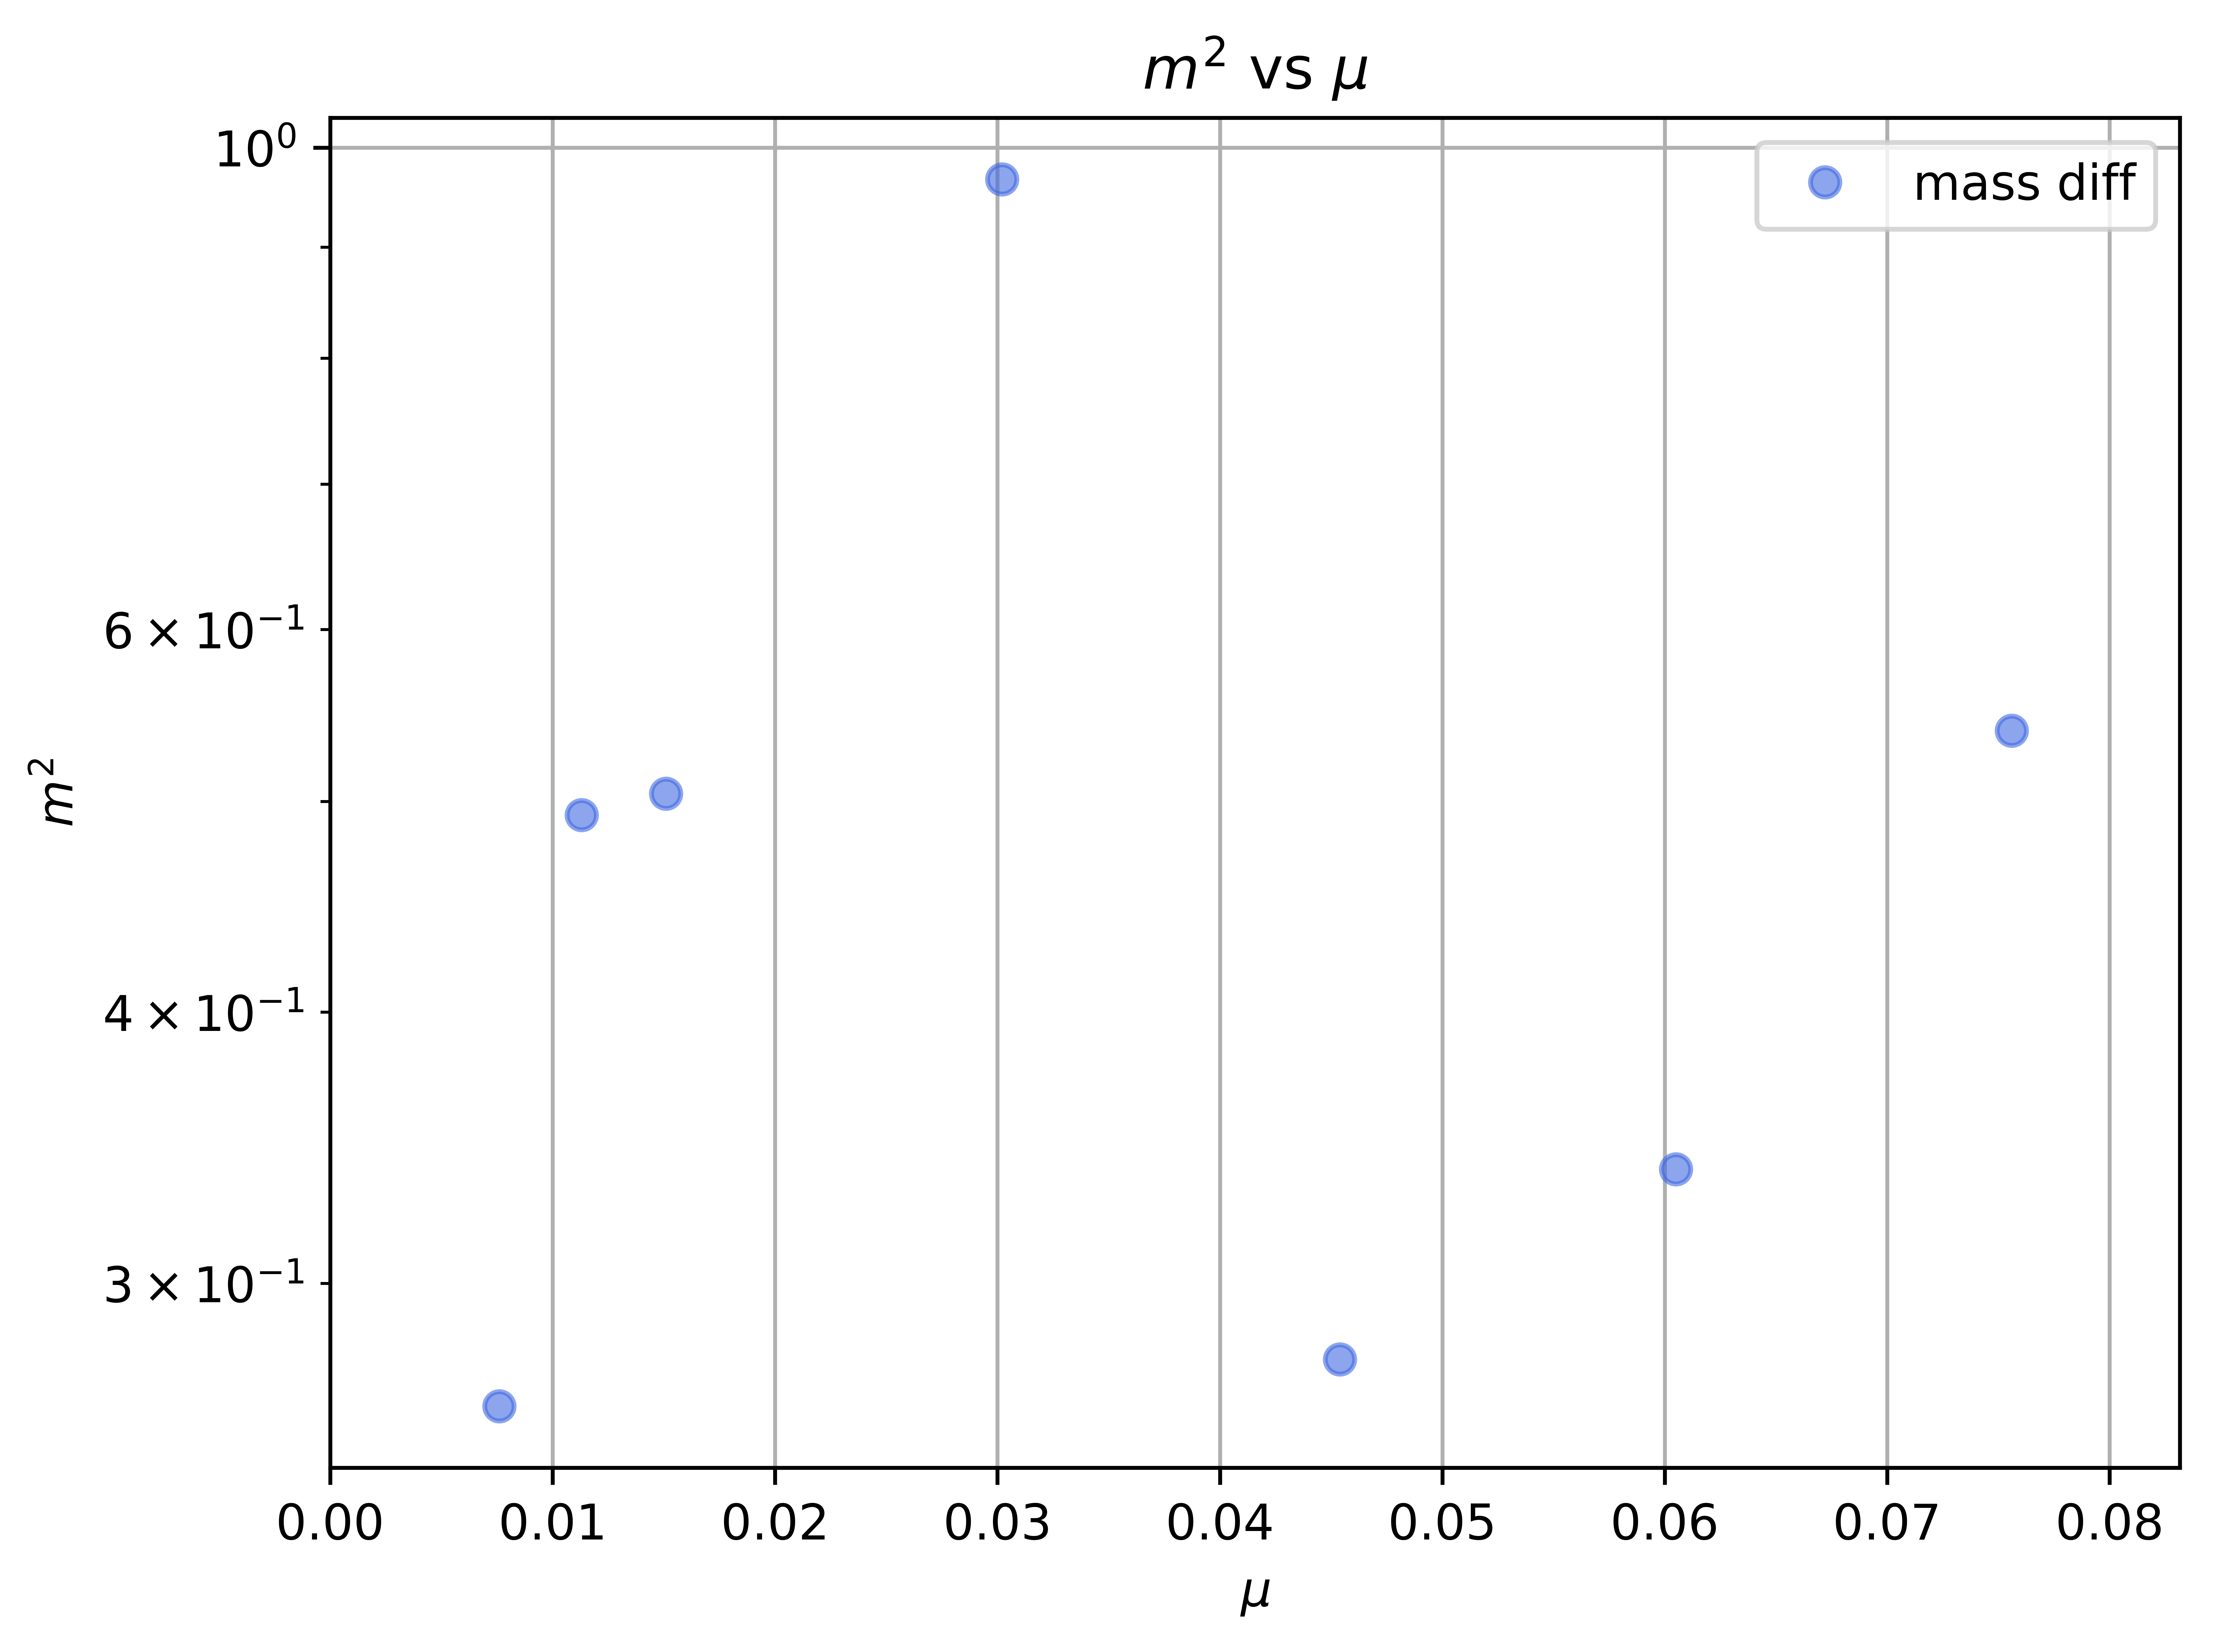

In [102]:
#do_my_plot(fit=False,save='mass_scaling_20240910.png')
do_my_plot(fit=False)
do_my_plot(fit=False,truem=False,eff=False,diff=True)

In [71]:
print("\nM2 eff - true")
chi2(sqM_true,M2_eff,M2_eff_std) 

print("\nM2t eff - true ")
chi2(sqM_true,M2t_eff,M2t_eff_std) 

print("\nM2 fit - true ")
chi2(sqM_true,M2_fit,M2_fit_std) 

print("\nM2t fit - true")
chi2(sqM_true,M2t_fit,M2t_fit_std)

print("\nM2 fit vs eff")
chi2(M2_fit,M2_eff,M2_eff_std) 

print("\nM2t fit vs eff")
chi2(M2t_fit,M2t_eff,M2t_eff_std)

#chi2(sqM_true,excM2[::2],excM2_std[::2])
#chi2(sqM_true,excM2[1::2],excM2_std[1::2])


M2 eff - true


np.float64(0.05230117979104941)


M2t eff - true 


np.float64(6.064431964408063)


M2 fit - true 


np.float64(1.6461475322255101)


M2t fit - true


np.float64(14.1985657813045)


M2 fit vs eff


np.float64(0.36189979797235355)


M2t fit vs eff


np.float64(0.6164220593354636)

# Fit Check

## Correlators from Jackknife

In [34]:
delta = 1 #binning of the jackknife procedure (we delete delta conf for each replicate

corr_navg_resamp = np.asarray( [np.delete(corr_navg, list(range(iconf,min(iconf+delta,nconf))) ,axis=0) for iconf in range(0,nconf,delta)] )

nresamples = int(nconf/delta)


if verbose:
    print("(nresamples,nconf-delta,ncorr,tvals)")
    print(np.shape(corr_navg_resamp))

(nresamples,nconf-delta,ncorr,tvals)
(100, 99, 14, 32)


In [35]:
#first we take the correlator averaged over the gauge configurations (for each subsample)
corr_navg_resamp_gavg = corr_navg_resamp.mean(axis=1)

#we then estimate the mass also on the whole dataset
corr_navg_gavg = corr_navg.mean(axis=0)

if verbose:
    print("(nresamples,ncorr,tvals)")
    print(np.shape(corr_navg_resamp_gavg))
    print("(ncorr,tvals)")
    print(np.shape(corr_navg_gavg))

(nresamples,ncorr,tvals)
(100, 14, 32)
(ncorr,tvals)
(14, 32)


In [36]:
#the estimate is the mean of the replicates
corr_estimate = np.mean(corr_navg_resamp_gavg,axis=0) #(the replicate axis)
#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
corr_bias = (nresamples-1) * (corr_estimate-corr_navg_gavg)
#the std is given by the following formula (variance of replicates times n-1)
corr_std = np.array( [np.sqrt( (nresamples-1)/nresamples * np.sum( (corr_navg_resamp_gavg[:,icorr] - corr_estimate[icorr])**2,axis=0 ) ) for icorr in range(ncorr)]   ) 
#then we correct the estimate for the bias
corr_estimate_biascorr = corr_estimate-corr_bias

if verbose:
    print("(ncorr,tvals)")
    print(np.shape(corr_estimate_biascorr))
    print(np.shape(corr_std))

(ncorr,tvals)
(14, 32)
(14, 32)


## sinh fit

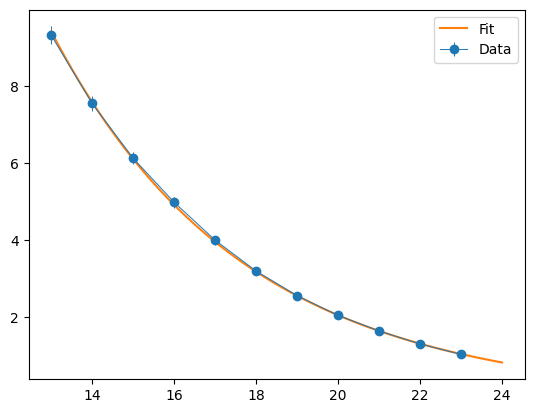

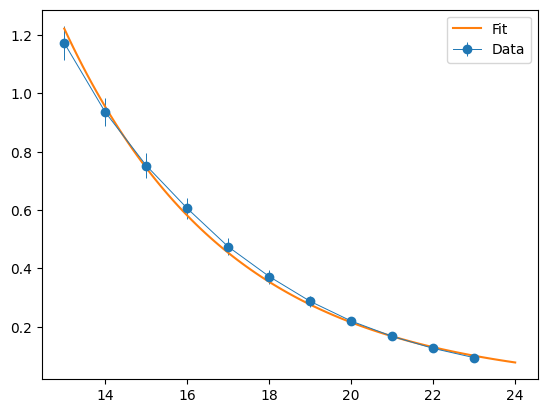

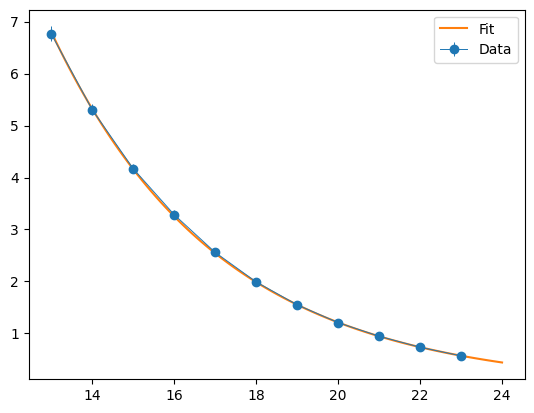

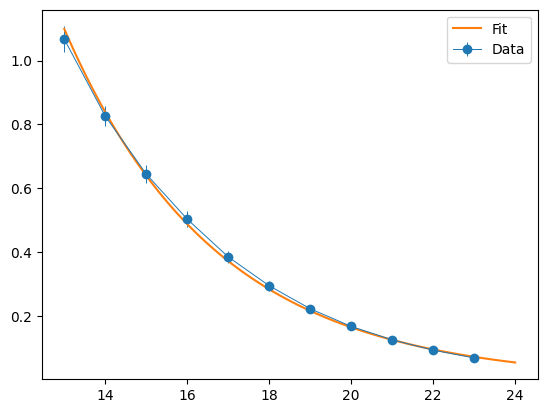

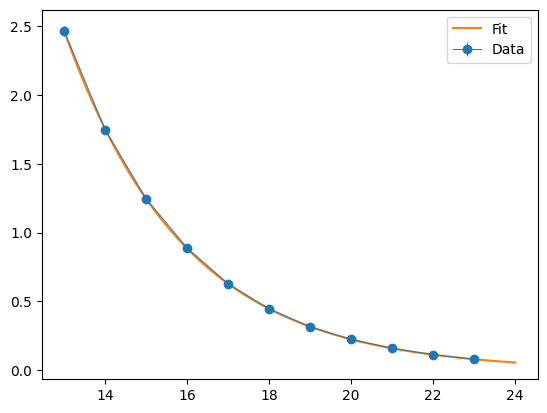

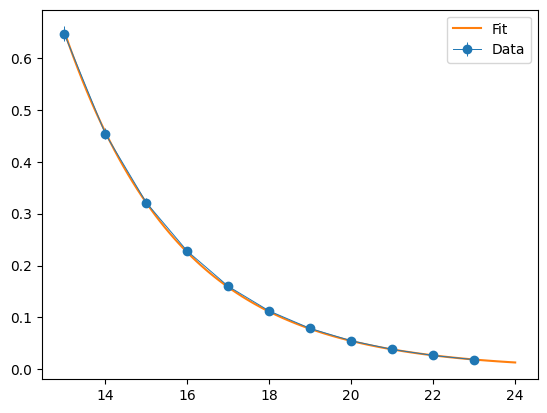

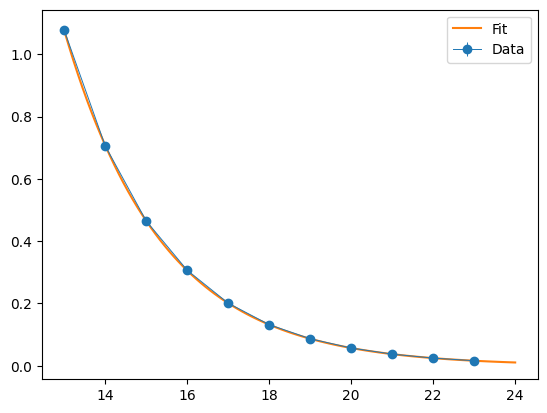

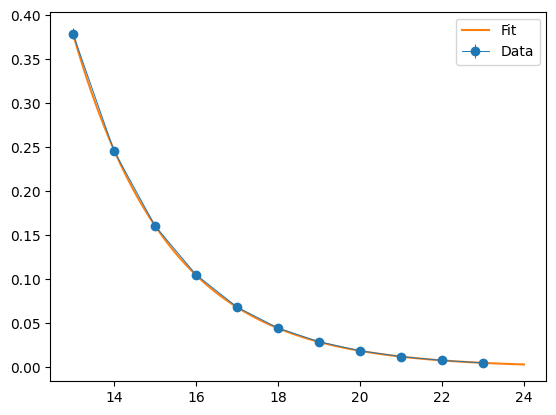

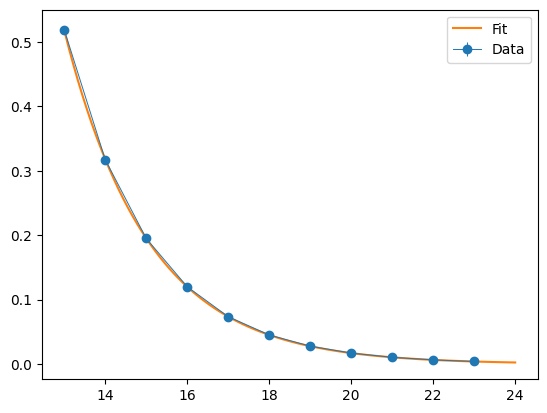

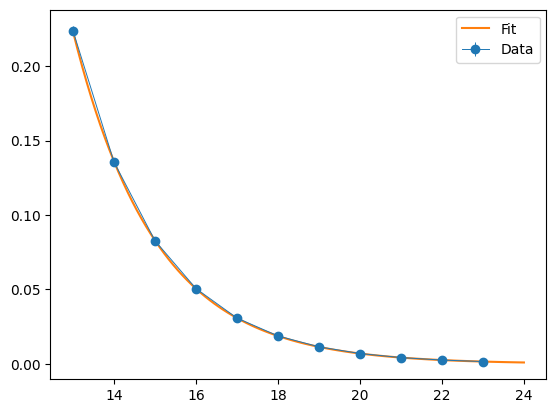

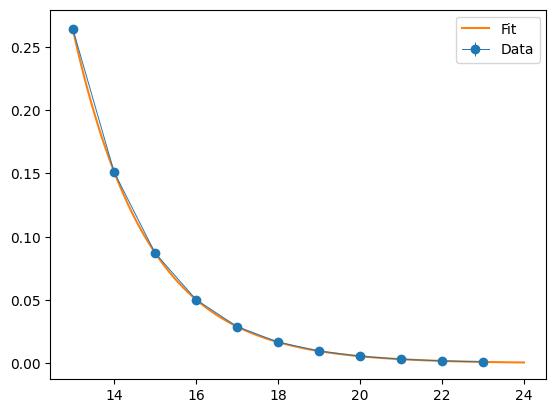

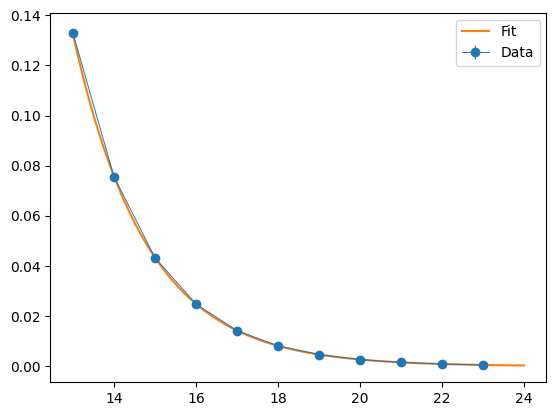

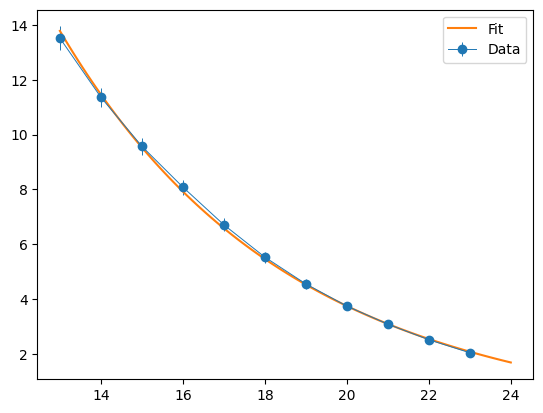

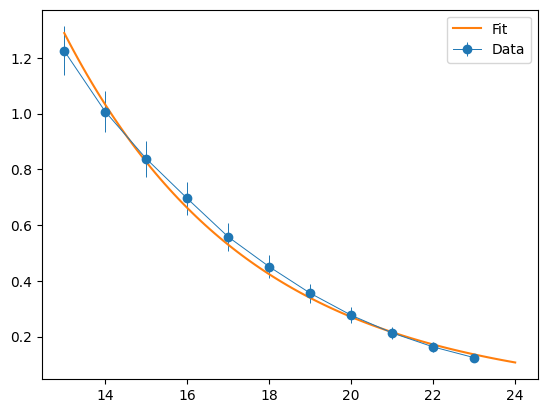

In [37]:
#fit on correlators
cut=8
l_off=5
r_off=0
times = np.arange(tvals)
fit_times=times[cut+l_off:-cut-r_off]
npoints=100
linspace_times = np.linspace(cut+l_off,tvals-cut-r_off,npoints)



mass_directfit = np.empty(shape=(ncorr),dtype=float)
mass_sig_directfit = np.empty(shape=(ncorr),dtype=float)
amp_directfit = np.empty(shape=(ncorr),dtype=float)

corr_directfit = np.empty(shape=(ncorr,npoints),dtype=float)


chi2_directfit = np.empty(shape=(ncorr),dtype=float)

#loop over correlators
for icorr in range(ncorr):


    guess_mass=true_masses[int(icorr/2)]
    guess_amp=corr_navg_gavg[icorr,int(tvals/2)].real * 2 * np.exp(-tvals/2 * guess_mass)
    guess=[guess_amp,guess_mass]
    
    fit_data=corr_estimate_biascorr[icorr,cut+l_off:-cut-r_off]
    fit_std=corr_std[icorr,cut+l_off:-cut-r_off]
    
    popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, sigma=fit_std, p0=guess)
    perr_x = np.sqrt(np.diag(pcov_x))
    mass_directfit[icorr] = popt_x[1]
    mass_sig_directfit[icorr] = perr_x[1]
    amp_directfit[icorr] = popt_x[0]
    corr_directfit[icorr] = fit_sinh_x(linspace_times,*popt_x)

    fit_result = fit_sinh_x(fit_times,*popt_x)

    chi2_directfit[icorr] = chi2(fit_result,fit_data,fit_std)


    _=plt.figure()
    _=plt.errorbar(times[cut+l_off:-cut-r_off],fit_data,corr_std[icorr,cut+l_off:-cut-r_off],marker='o',linewidth=0.7,label='Data')
    _=plt.plot(linspace_times,corr_directfit[icorr],label='Fit')
    #_=plt.xlim(cut,tvals-cut)
    #_=plt.ylim(np.min(corr_from_data[cut:-cut])*0.9, np.max(corr_from_data[cut:-cut])*1.1 )
    _=plt.legend()

In [38]:
print("\nM2 dirfit chi2")
chi2_directfit[::2]

print("\nM2t dirfit chi2")
chi2_directfit[1::2]


M2 dirfit chi2


array([0.0699161 , 0.03516238, 0.01271008, 0.00831607, 0.01064664,
       0.01880899, 0.14039091])


M2t dirfit chi2


array([0.37471403, 0.33985918, 0.09703784, 0.02188424, 0.01043782,
       0.01934872, 0.26845712])

In [39]:
mass_directfit[::2]
mass_sig_directfit[::2]

mass_directfit[1::2]
mass_sig_directfit[1::2]

array([0.21604639, 0.24584555, 0.34181642, 0.41950536, 0.48784833,
       0.5509808 , 0.18350743])

array([0.00085999, 0.00053639, 0.00024907, 0.0001717 , 0.00017215,
       0.00020743, 0.0015126 ])

array([0.24746204, 0.27058008, 0.35365955, 0.4278461 , 0.4950757 ,
       0.55778472, 0.2219221 ])

array([0.00386466, 0.00284341, 0.00093101, 0.00034399, 0.00020184,
       0.0002436 , 0.00499124])

In [40]:
m_dirfit = mass_directfit[::2]
m2_dirfit = mass_directfit[::2]**2
m2_sig_dirfit = 2 * np.abs(m_dirfit) * mass_sig_directfit[::2]

mt_dirfit = mass_directfit[1::2]
m2t_dirfit = mass_directfit[1::2]**2
m2t_sig_dirfit = 2 * np.abs(mt_dirfit) * mass_sig_directfit[1::2]

In [41]:
guess_par = [ ( m2_dirfit[-1]-m2_dirfit[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, m2_dirfit, sigma= m2_sig_dirfit, p0=guess_par)
m2dirfit_eff_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nm2 dirfit")
print(popt)
print(np.sqrt(np.diag(pcov)))

guess_par = [ ( m2t_dirfit[-1]-m2t_dirfit[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, m2t_dirfit, sigma= m2t_sig_dirfit, p0=guess_par)
m2dirfit_eff_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nm2t dirfit")
print(popt)
print(np.sqrt(np.diag(pcov)))

guess_par = [ ( sqM_true[-1]-sqM_true[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, sqM_true, p0=guess_par)
fit_reference = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nM2 true")
print(popt)
print(np.sqrt(np.diag(pcov)))


print("\nm2 dirfit - true ")
chi2(sqM_true,m2_dirfit,m2_sig_dirfit) 

print("\nm2 dirfit - eff ")
chi2(M2_eff,m2_dirfit,m2_sig_dirfit) 
chi2(M2_eff,m2_dirfit,M2_eff_std) 


m2 dirfit
[ 3.98585948e+00 -2.48972129e-03]
[0.06146219 0.00295316]

m2t dirfit
[ 4.09533017e+00 -1.19327720e-03]
[0.092105   0.00557073]

M2 true
[ 3.95565539e+00 -1.52047020e-04]
[0.05914152 0.00252526]

m2 dirfit - true 


np.float64(17.599062756564088)


m2 dirfit - eff 


np.float64(33.79601045773644)

np.float64(0.12072682051008699)

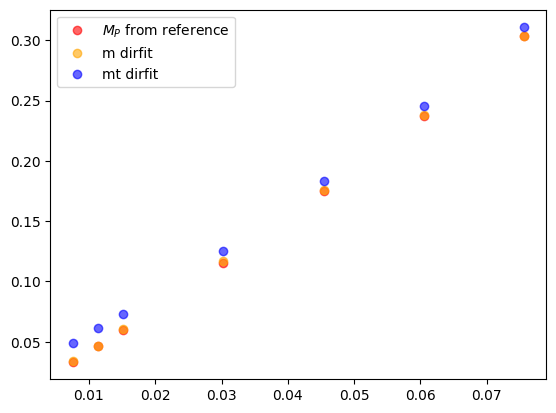

In [42]:


_=plt.errorbar(mus,m_dirfit**2,yerr=m2_sig_dirfit,marker='o',linewidth=0,label=r"m dirfit",color='orange',alpha=0.6)
_=plt.errorbar(mus,mt_dirfit**2,yerr=m2t_sig_dirfit,marker='o',linewidth=0,label=r"mt dirfit",color='blue',alpha=0.6)
_=plt.plot(mus,sqM_true,marker='o',linewidth=0,label=r"$M_P$ from reference",color='red',alpha=0.6)
plt.legend()

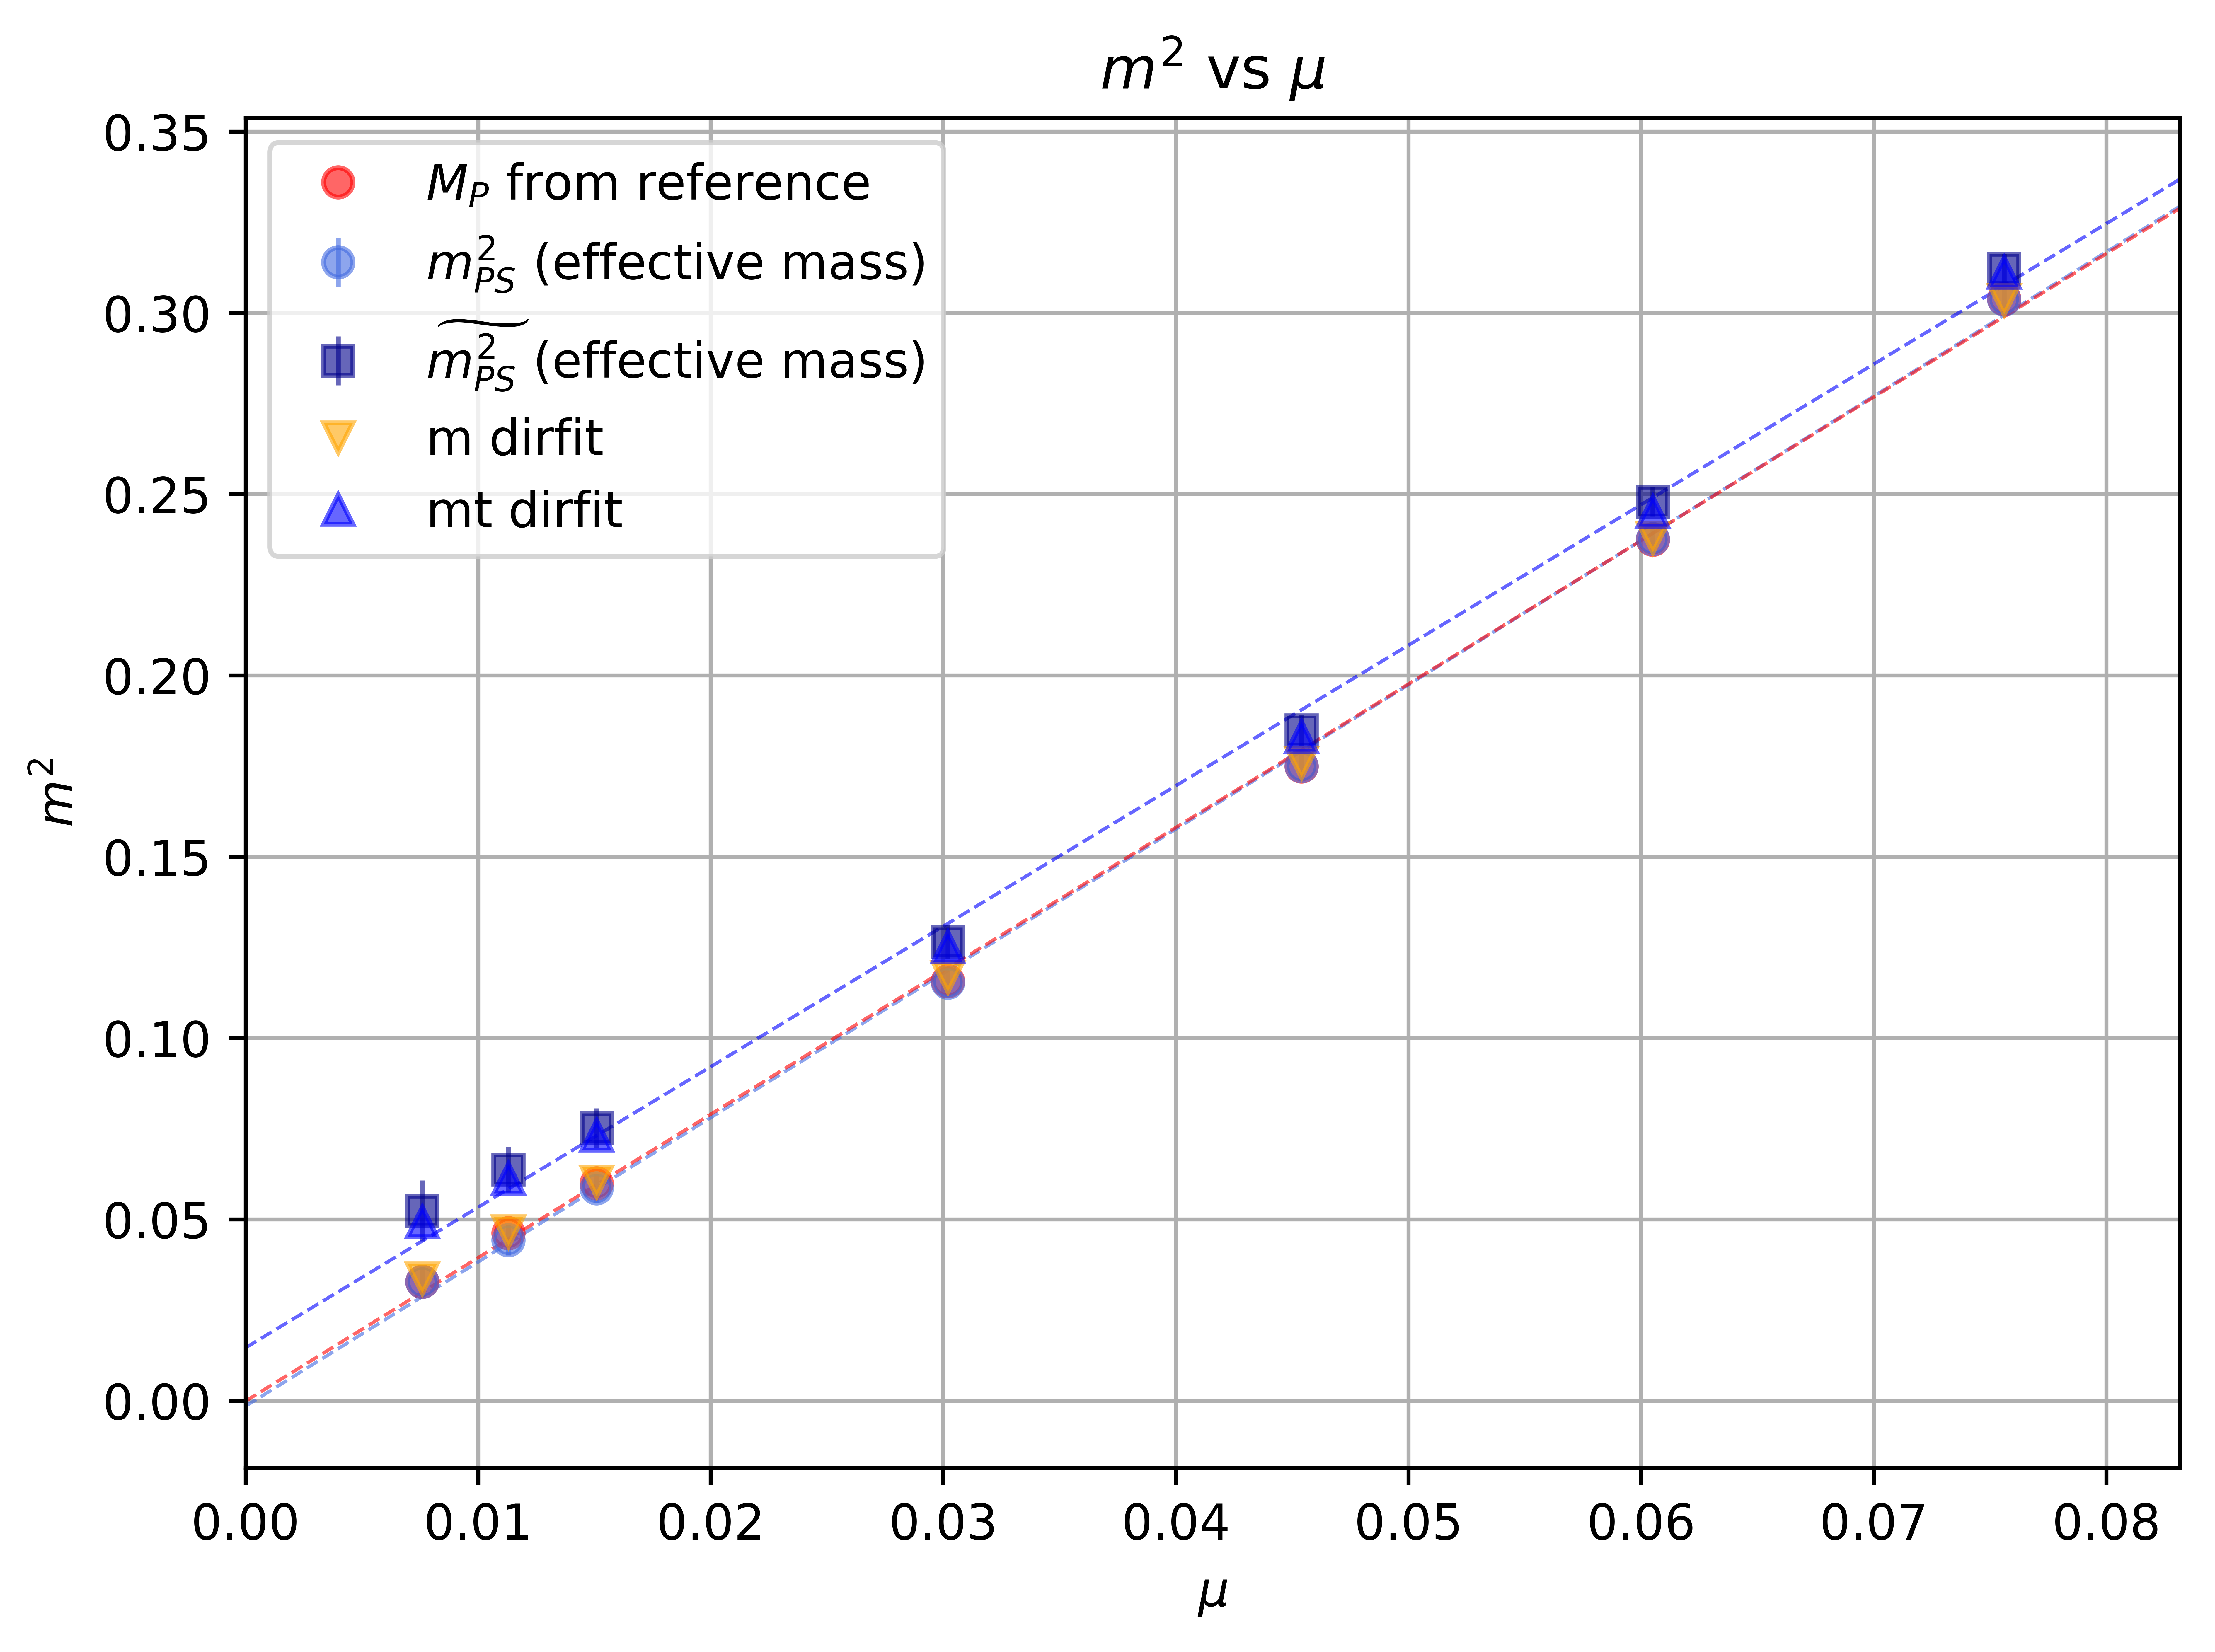

In [43]:
do_my_plot(fit=False,eff=True,truem=True,dirfit=False)

_=plt.errorbar(mus,m_dirfit**2,yerr=m2_sig_dirfit,marker='v',linewidth=0,label=r"m dirfit",color='orange',alpha=0.6)
_=plt.errorbar(mus,mt_dirfit**2,yerr=m2t_sig_dirfit,marker='^',linewidth=0,label=r"mt dirfit",color='blue',alpha=0.6)

#_=plt.plot(mus,m2_dirfit,marker='^',linewidth=0,label=r"m dirfit",color='purple',alpha=0.6)
#_=plt.plot(mu_range,m2dirfit_eff_linfit,linewidth =0.7,linestyle='dashed',color='purple',alpha=0.6)
#_=plt.plot(mus,m2t_dirfit,marker='v',linewidth=0,label=r"mt dirfit",color='brown',alpha=0.6)
#_=plt.plot(mu_range,m2tdirfit_eff_linfit,linewidth =0.7,linestyle='dashed',color='brown',alpha=0.6)
#_=plt.plot(mus,sqM_true,marker='o',linewidth=0,label=r"$M_P$ from reference",color='red',alpha=0.6)
plt.legend()

In [44]:
'''
cut=8

#loop over correlators
for icorr in range(ncorr):






    #direct fit
    #mass from fit for each of the replicate
    guess_mass=true_masses[int(icorr/2)]
    cut=8
    fit_times=times[cut:-cut]
    guess_amp=corr_navg_gavg[icorr,int(tvals/2)].real * 2 * np.exp(-tvals/2 * guess_mass)
    guess=[guess_amp,guess_mass]
    fit_data=corr_navg_gavg[icorr,cut:-cut].real
    popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, p0=guess)
    perr_x = np.sqrt(np.diag(pcov_x))
    fit_mass_array_jacktotal[icorr] = popt_x[1]
    fit_amp_array_jacktotal[icorr] = popt_x[0]
    



    

    corr_from_data = corr_navg_gavg[icorr]

    corr_from_fit = fit_sinh_x(linspace_times,amp_fit[icorr],M_fit[icorr])

    _=plt.figure()
    _=plt.plot(times,corr_from_data,'-o',linewidth=0.7,label='Data')
    _=plt.plot(linspace_times,corr_from_fit,label='Fit')
    _=plt.xlim(cut,tvals-cut)
    _=plt.ylim(np.min(corr_from_data[cut:-cut])*0.9, np.max(corr_from_data[cut:-cut])*1.1 )
    _=plt.legend()
    '''

"\ncut=8\n\n#loop over correlators\nfor icorr in range(ncorr):\n\n\n\n\n\n\n    #direct fit\n    #mass from fit for each of the replicate\n    guess_mass=true_masses[int(icorr/2)]\n    cut=8\n    fit_times=times[cut:-cut]\n    guess_amp=corr_navg_gavg[icorr,int(tvals/2)].real * 2 * np.exp(-tvals/2 * guess_mass)\n    guess=[guess_amp,guess_mass]\n    fit_data=corr_navg_gavg[icorr,cut:-cut].real\n    popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, p0=guess)\n    perr_x = np.sqrt(np.diag(pcov_x))\n    fit_mass_array_jacktotal[icorr] = popt_x[1]\n    fit_amp_array_jacktotal[icorr] = popt_x[0]\n    \n\n\n\n    \n\n    corr_from_data = corr_navg_gavg[icorr]\n\n    corr_from_fit = fit_sinh_x(linspace_times,amp_fit[icorr],M_fit[icorr])\n\n    _=plt.figure()\n    _=plt.plot(times,corr_from_data,'-o',linewidth=0.7,label='Data')\n    _=plt.plot(linspace_times,corr_from_fit,label='Fit')\n    _=plt.xlim(cut,tvals-cut)\n    _=plt.ylim(np.min(corr_from_data[cut:-cut])*0.9, np.max(corr_from

## exp fit

In [45]:
def exp_fit(t,a1,m,b1):
    #T=tvals-1
    return a1*np.exp(-m*t) + b1*np.exp(m*t)


icorr0
[ 1.38087495e+02  2.07396948e-01 -1.79448717e-03]

icorr1
[ 1.89352086e+01  2.14311167e-01 -5.11166199e-04]

icorr2
[ 1.53919139e+02  2.40519114e-01 -3.10247613e-04]

icorr3
[ 2.66231357e+01  2.47856493e-01 -1.21873004e-04]

icorr4
[ 2.06505004e+02  3.40827280e-01 -1.41697334e-06]

icorr5
[ 6.05050686e+01  3.49143302e-01 -8.41213060e-07]

icorr6
[2.54686214e+02 4.20355907e-01 1.98782493e-08]

icorr7
[9.99836574e+01 4.28613326e-01 5.34288907e-09]

icorr8
[3.03344941e+02 4.89869700e-01 4.45555213e-09]

icorr9
[1.45521044e+02 4.97876709e-01 2.10962596e-09]

icorr10
[3.54544517e+02 5.53790173e-01 5.13822998e-10]

icorr11
[1.97992584e+02 5.61551583e-01 2.72045465e-10]

icorr12
[ 1.20516316e+02  1.67815084e-01 -1.47218702e-02]

icorr13
[ 1.21179773e+01  1.76010245e-01 -2.29159293e-03]


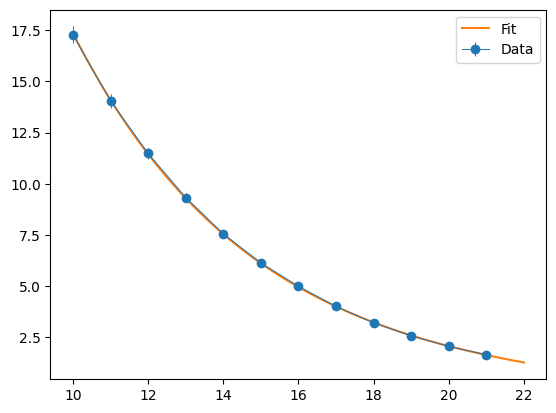

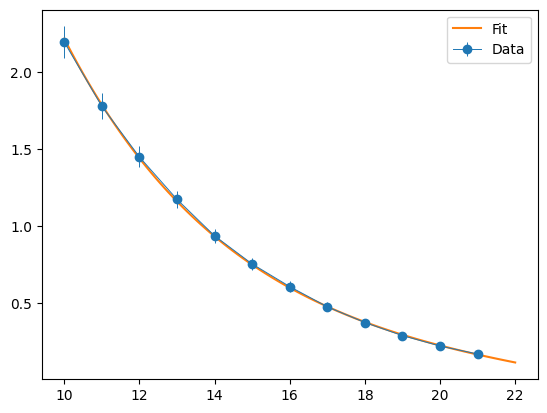

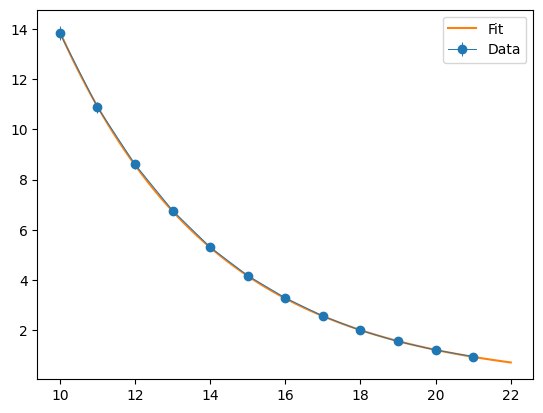

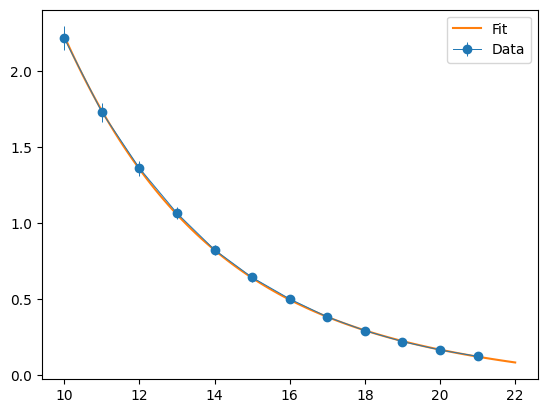

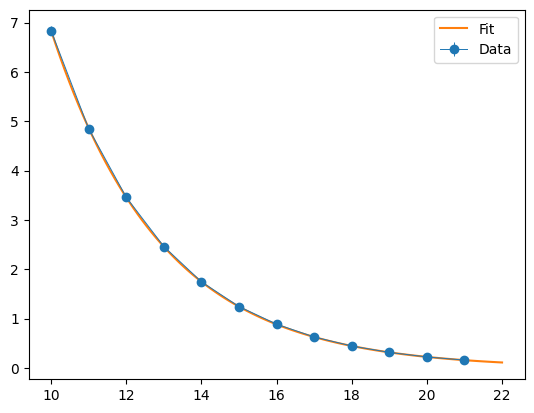

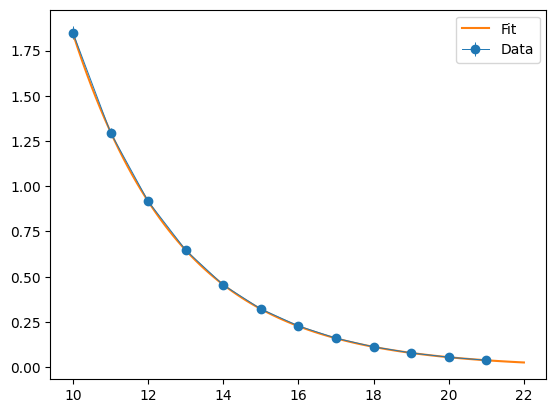

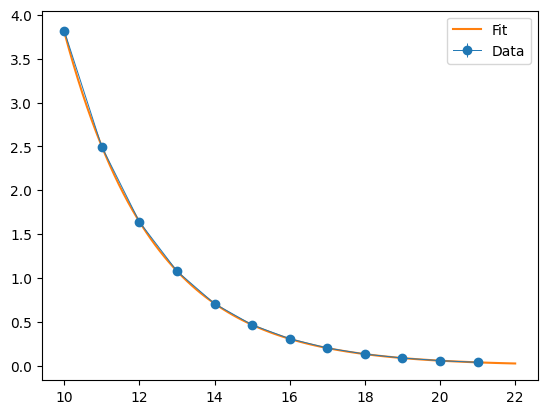

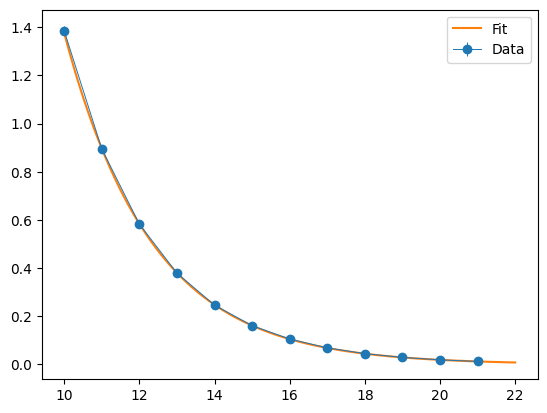

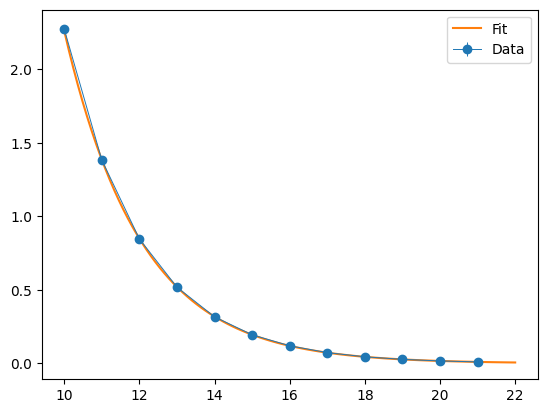

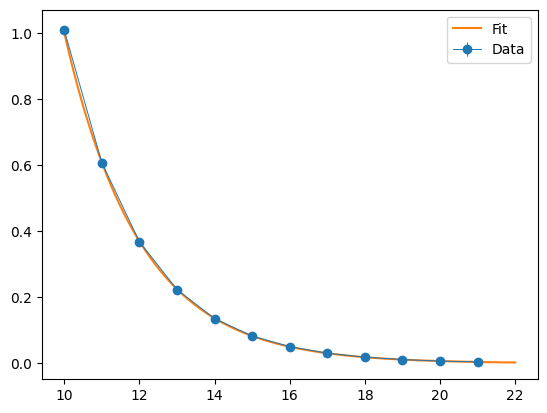

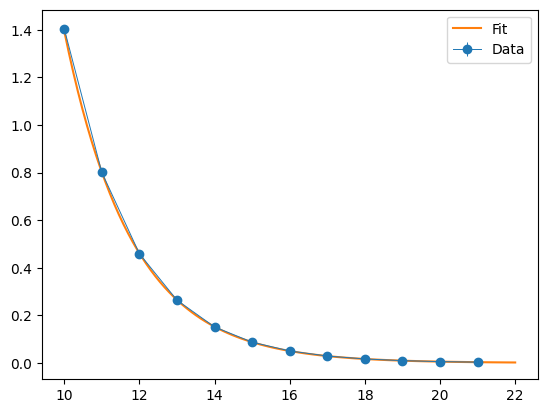

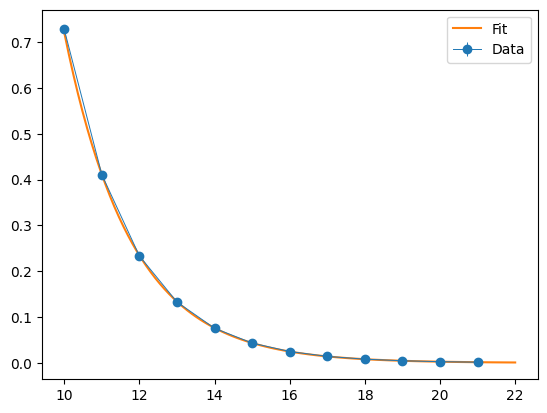

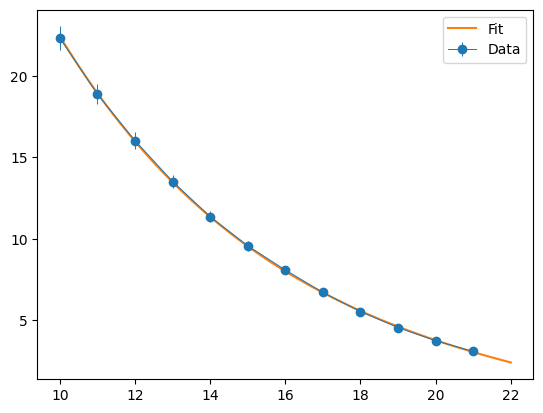

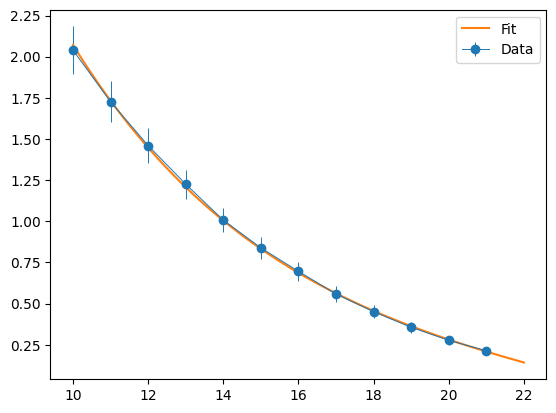

In [46]:
#fit on correlators
cut=10
times = np.arange(tvals)
fit_times=times[cut:-cut]
npoints=100
linspace_times = np.linspace(cut,tvals-cut,npoints)



mass_directfit = np.empty(shape=(ncorr),dtype=float)
mass_sig_directfit = np.empty(shape=(ncorr),dtype=float)
#amp_directfit = np.empty(shape=(ncorr),dtype=float)

corr_directfit = np.empty(shape=(ncorr,npoints),dtype=float)


chi2_directfit = np.empty(shape=(ncorr),dtype=float)

#loop over correlators
for icorr in range(ncorr):

    guess_m = true_masses[int(icorr/2)]
    
    my_amp = corr_estimate_biascorr[icorr,int(tvals/2)] / np.sinh( (tvals-1-tvals/2) * guess_m )


    
    my_amp = corr_estimate_biascorr[icorr,int(tvals/2)] / np.sinh( (tvals-1-tvals/2) * guess_m )
    guess_a1 = my_amp * np.exp(guess_m*(tvals-1)) #corr_estimate_biascorr[icorr,int(tvals/2)] / np.exp(-tvals/2 * guess_m)
    guess_b1 = -my_amp * np.exp(-guess_m*(tvals-1)) #corr_estimate_biascorr[icorr,int(tvals/2)] / np.exp(-tvals/2 * guess_m)
    #guess_e2 = guess_m

    #guess_a1 = 1
    #guess_b1 = 1
    
    guess=[guess_a1,guess_m,guess_b1]#,guess_e2]
    
    fit_data=corr_estimate_biascorr[icorr,cut:-cut]
    fit_std=corr_std[icorr,cut:-cut]
    
    
    popt_x,pcov_x = curve_fit(exp_fit, fit_times, fit_data, sigma=fit_std, p0=guess,maxfev=5000)
    perr_x = np.sqrt(np.diag(pcov_x))

    print(f"\nicorr{icorr}")
    print(popt_x)
    
    mass_directfit[icorr] = popt_x[1]
    mass_sig_directfit[icorr] = perr_x[1]
    #amp_directfit[icorr] = popt_x[0]
    
    corr_directfit[icorr] = exp_fit(linspace_times,*popt_x)
    

    fit_result = exp_fit(fit_times,*popt_x)

    chi2_directfit[icorr] = chi2(fit_result,fit_data,fit_std)


    _=plt.figure()
    _=plt.errorbar(times[cut:-cut],fit_data,corr_std[icorr,cut:-cut],marker='o',linewidth=0.7,label='Data')
    _=plt.plot(linspace_times,corr_directfit[icorr],label='Fit')
    #_=plt.xlim(cut,tvals-cut)
    #_=plt.ylim(np.min(corr_from_data[cut:-cut])*0.9, np.max(corr_from_data[cut:-cut])*1.1 )
    _=plt.legend()

In [47]:
print("\nM2 dirfit chi2")
chi2_directfit[::2]

print("\nM2t dirfit chi2")
chi2_directfit[1::2]


M2 dirfit chi2


array([0.03852944, 0.03777192, 0.01470652, 0.02509434, 0.09542405,
       0.20934006, 0.03734146])


M2t dirfit chi2


array([0.03454664, 0.03292107, 0.01095496, 0.05217667, 0.1425868 ,
       0.25843173, 0.02294083])

In [48]:
mass_directfit[::2]
mass_sig_directfit[::2]

mass_directfit[1::2]
mass_sig_directfit[1::2]

array([0.20739695, 0.24051911, 0.34082728, 0.42035591, 0.4898697 ,
       0.55379017, 0.16781508])

array([0.00102378, 0.00080223, 0.00030845, 0.00031006, 0.0005046 ,
       0.00065075, 0.00144824])

array([0.21431117, 0.24785649, 0.3491433 , 0.42861333, 0.49787671,
       0.56155158, 0.17601024])

array([0.00189268, 0.00132741, 0.00038419, 0.00058298, 0.00076105,
       0.00086361, 0.00257389])

In [49]:
m_dirfit = mass_directfit[::2]
m2_dirfit = mass_directfit[::2]**2
m2_sig_dirfit = 2 * np.abs(m_dirfit) * mass_sig_directfit[::2]

mt_dirfit = mass_directfit[1::2]
m2t_dirfit = mass_directfit[1::2]**2
m2t_sig_dirfit = 2 * np.abs(mt_dirfit) * mass_sig_directfit[1::2]

m2_dirfit
m2t_dirfit

array([0.04301349, 0.05784944, 0.11616323, 0.17669909, 0.23997232,
       0.30668356, 0.0281619 ])

array([0.04592928, 0.06143284, 0.12190105, 0.18370938, 0.24788122,
       0.31534018, 0.03097961])

In [50]:
murange = np.linspace(0,np.max(mu1)*1.1,100)

guess_par = [ ( m2_dirfit[-1]-m2_dirfit[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, m2_dirfit, sigma= m2_sig_dirfit, p0=guess_par)
m2dirfit_eff_linfit = fit_lin(murange,*popt)
print("\nm2 dirfit")
print(popt)
print(np.sqrt(np.diag(pcov)))

guess_par = [ ( m2t_dirfit[-1]-m2t_dirfit[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, m2t_dirfit, sigma= m2t_sig_dirfit, p0=guess_par)
m2tdirfit_eff_linfit = fit_lin(murange,*popt)
print("\nm2t dirfit")
print(popt)
print(np.sqrt(np.diag(pcov)))

guess_par = [ ( sqM_true[-1]-sqM_true[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, sqM_true, p0=guess_par)
fit_reference = fit_lin(murange,*popt)
print("\nM2 true")
print(popt)
print(np.sqrt(np.diag(pcov)))


print("\nm2 dirfit - true ")
chi2(sqM_true,m2_dirfit,m2_sig_dirfit) 

print("\nm2 dirfit - eff ")
chi2(M2_eff,m2_dirfit,m2_sig_dirfit) 
chi2(M2_eff,m2_dirfit,M2_eff_std)

print("\nm2t dirfit - eff ")
chi2(M2t_eff,m2t_dirfit,m2t_sig_dirfit) 
chi2(M2t_eff,m2t_dirfit,M2t_eff_std)


m2 dirfit
[ 4.01265463 -0.00401601]
[0.04955999 0.00180548]

m2t dirfit
[ 4.13643511e+00 -2.47816683e-03]
[0.04252441 0.00154897]

M2 true
[ 3.95565539e+00 -1.52047020e-04]
[0.05914152 0.00252526]

m2 dirfit - true 


np.float64(39.10198902671679)


m2 dirfit - eff 


np.float64(29.31301966006825)

np.float64(0.36904982579701223)


m2t dirfit - eff 


np.float64(254.77432147513153)

np.float64(3.205983832845128)

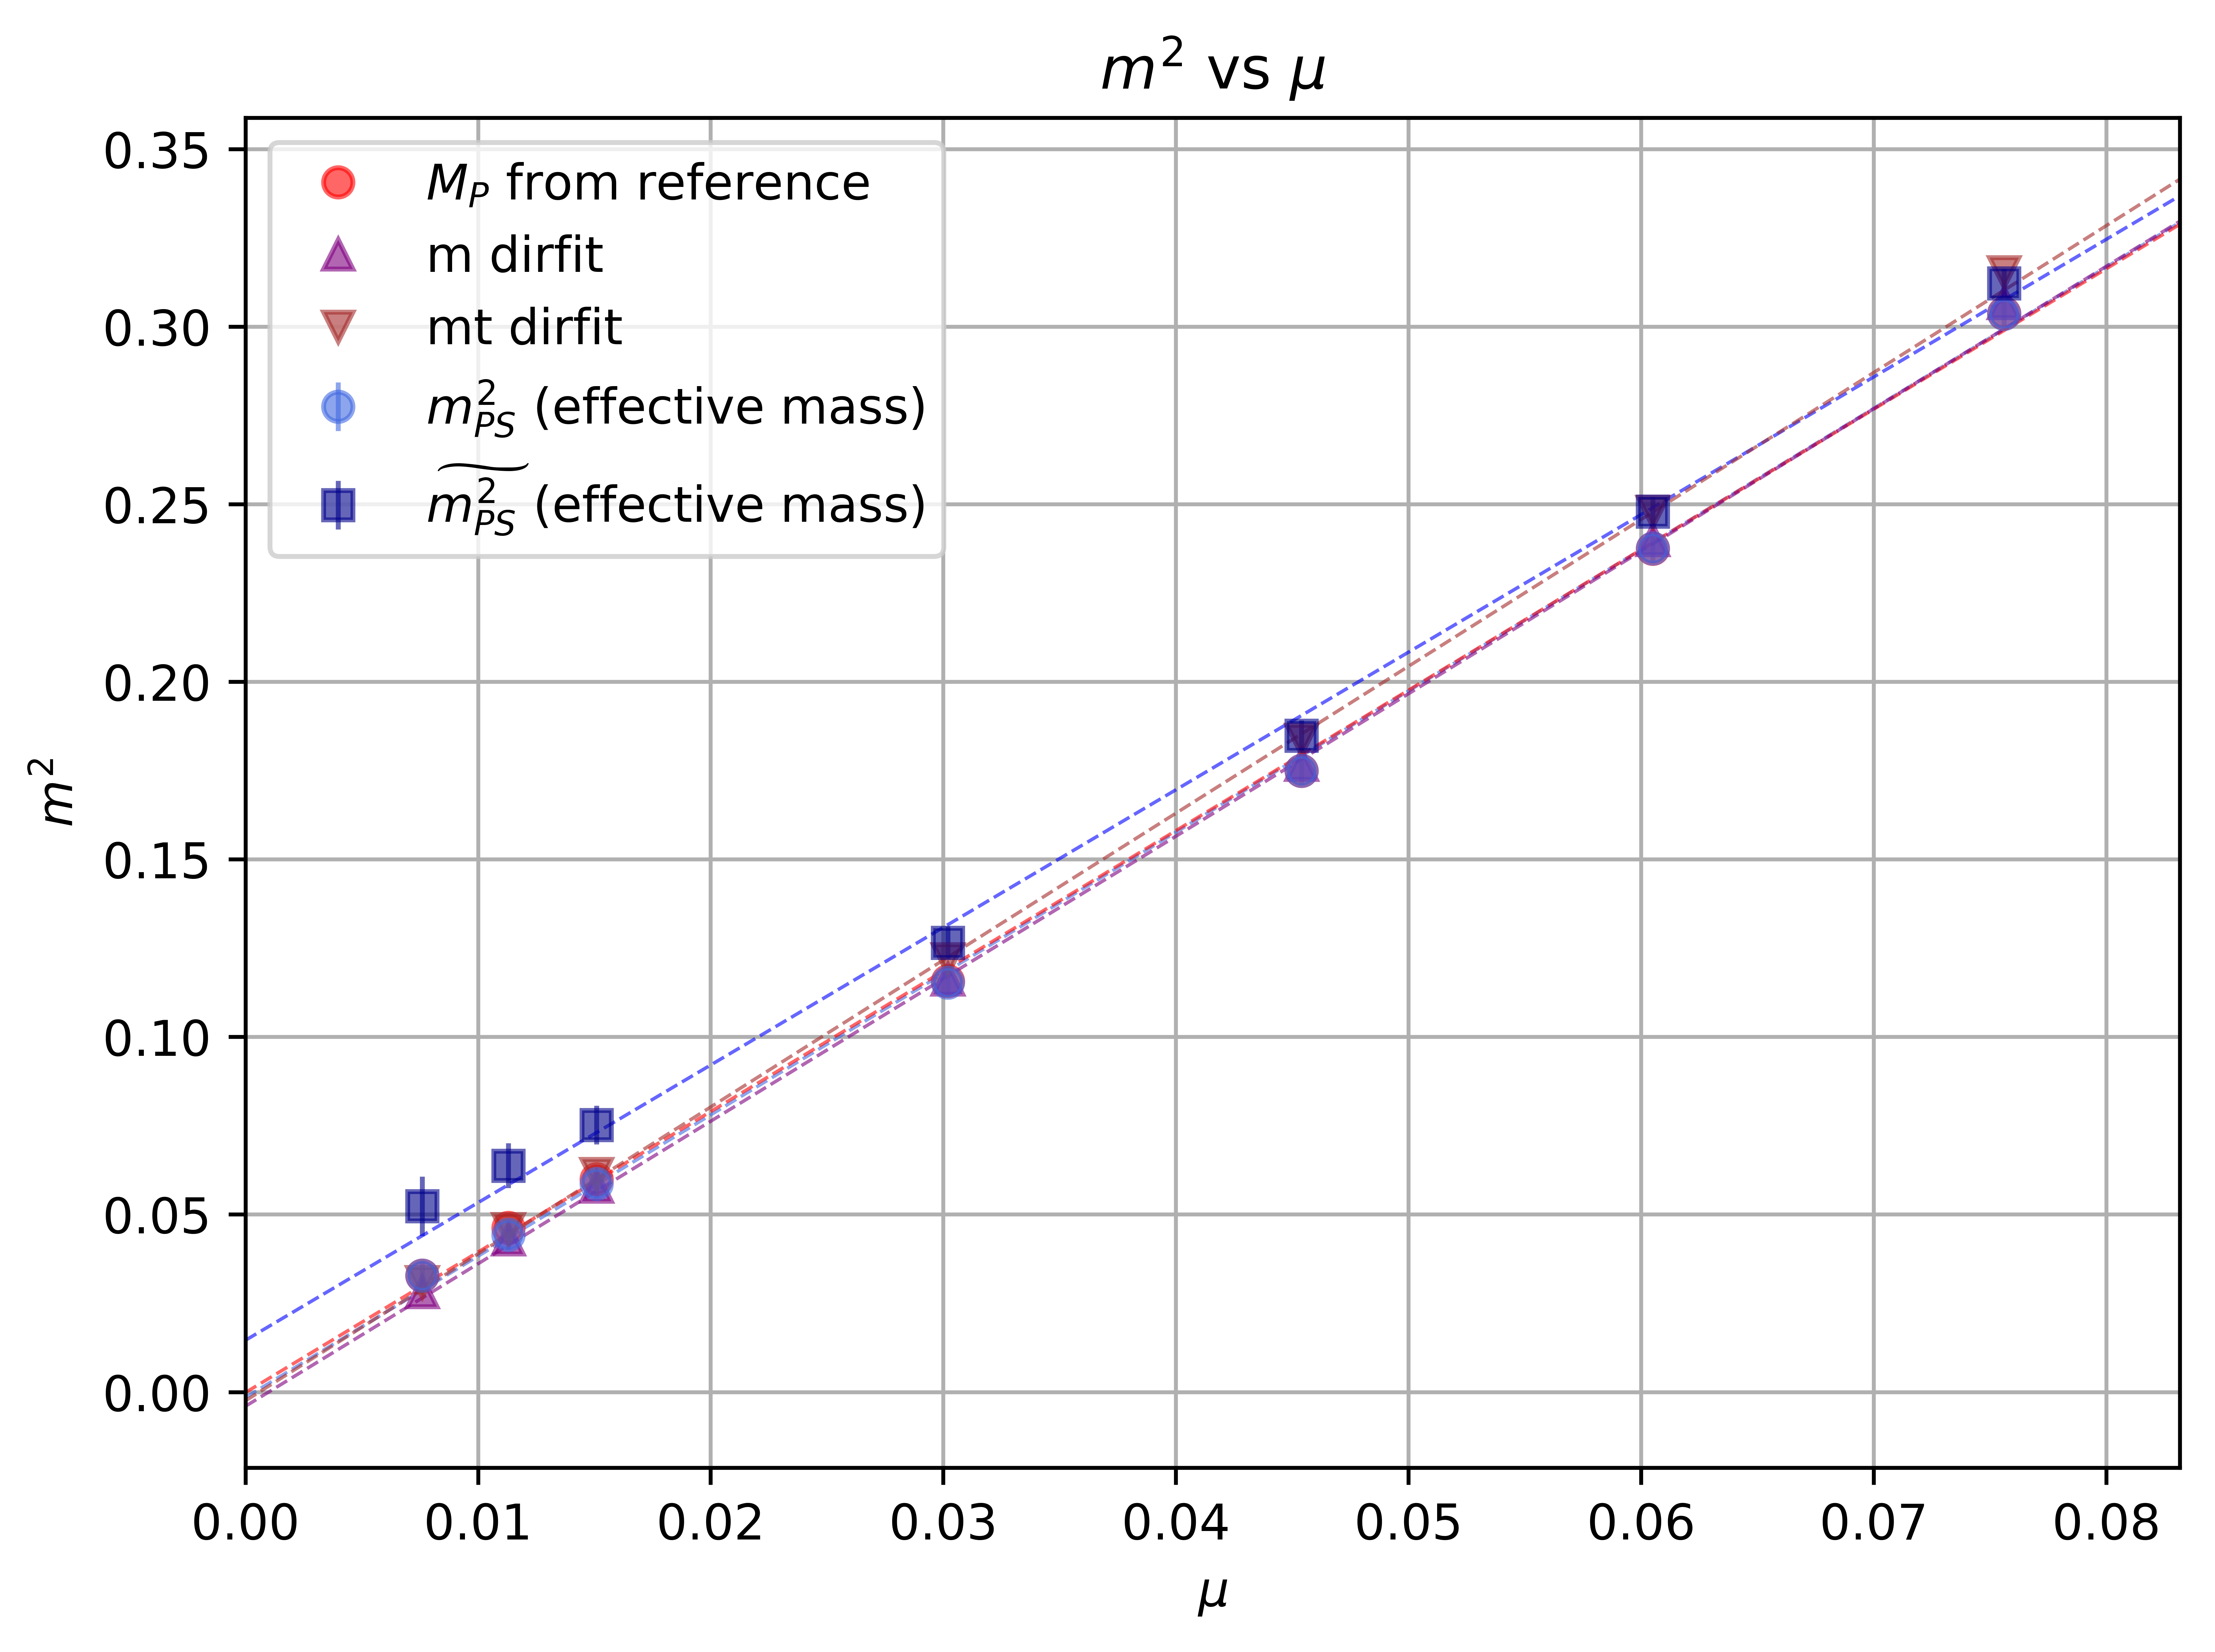

In [51]:
#do_my_plot(fit=False,eff=False,truem=False,dirfit=True)
do_my_plot(fit=False,eff=True,truem=True,dirfit=False)

_=plt.plot(mus,m2_dirfit,marker='^',linewidth=0,label=r"m dirfit",color='purple',alpha=0.6)
_=plt.plot(mu_range,m2dirfit_eff_linfit,linewidth =0.7,linestyle='dashed',color='purple',alpha=0.6)
_=plt.plot(mus,m2t_dirfit,marker='v',linewidth=0,label=r"mt dirfit",color='brown',alpha=0.6)
_=plt.plot(mu_range,m2tdirfit_eff_linfit,linewidth =0.7,linestyle='dashed',color='brown',alpha=0.6)
#_=plt.plot(mus,sqM_true,marker='o',linewidth=0,label=r"$M_P$ from reference",color='red',alpha=0.6)
plt.legend()

# Extra check

In [52]:
#M_eff
#M_eff_std

In [53]:
#def eff_mass_func(t,mps,E1,c1,c2):
 #   return mps+c1*np.exp(-E1*t)+c2*np.exp(-2*mps*(tvals-1-t))
#def eff_mass_func(t,mps,E1,c1):
 #   return mps+c1*np.exp(-E1*t)#+c2*np.exp(-2*mps*(tvals-1-t))

In [54]:
'''
cut=4
times = np.arange(tvals)
fit_times_m=times[cut:-cut-1]+0.5

extra_check_masses = np.empty(shape=(ncorr),dtype=float)
extra_check_masses_std = np.empty(shape=(ncorr),dtype=float)

for icorr in range(ncorr):

    meff = eff_estimate_biascorr[icorr,cut:-cut]
    meff_std = eff_std[icorr,cut:-cut]
    
    guess_par = [ true_masses[int(icorr/2)] , true_masses[int(icorr/2)], true_masses[int(icorr/2)], true_masses[int(icorr/2)] ]
    #guess_par = [ true_masses[int(icorr/2)] , true_masses[int(icorr/2)], 0.0 ]
    popt,pcov = curve_fit(eff_mass_func, fit_times_m, meff, sigma= meff_std, p0=guess_par,maxfev=5000)

    print(popt)
    #print(pcov)
    extra_check_masses[icorr] = popt[0]
    extra_check_masses_std[icorr] = np.sqrt(np.diag(pcov))[0]

excM2 = extra_check_masses**2
excM2_std = 2*extra_check_masses*extra_check_masses_std
'''

'\ncut=4\ntimes = np.arange(tvals)\nfit_times_m=times[cut:-cut-1]+0.5\n\nextra_check_masses = np.empty(shape=(ncorr),dtype=float)\nextra_check_masses_std = np.empty(shape=(ncorr),dtype=float)\n\nfor icorr in range(ncorr):\n\n    meff = eff_estimate_biascorr[icorr,cut:-cut]\n    meff_std = eff_std[icorr,cut:-cut]\n    \n    guess_par = [ true_masses[int(icorr/2)] , true_masses[int(icorr/2)], true_masses[int(icorr/2)], true_masses[int(icorr/2)] ]\n    #guess_par = [ true_masses[int(icorr/2)] , true_masses[int(icorr/2)], 0.0 ]\n    popt,pcov = curve_fit(eff_mass_func, fit_times_m, meff, sigma= meff_std, p0=guess_par,maxfev=5000)\n\n    print(popt)\n    #print(pcov)\n    extra_check_masses[icorr] = popt[0]\n    extra_check_masses_std[icorr] = np.sqrt(np.diag(pcov))[0]\n\nexcM2 = extra_check_masses**2\nexcM2_std = 2*extra_check_masses*extra_check_masses_std\n'

In [55]:
#excM2

In [56]:
'''
mu_range = np.linspace(0,np.max(mu1)*1.1,100)

excM2_ = excM2[::2]
excM2_std_ = excM2_std[::2]
excM2_t = excM2[1::2]
excM2_std_t = excM2_std[1::2]

guess_par = [ ( excM2_[-1]+excM2_[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, excM2_, sigma= excM2_std_, p0=guess_par)
excM2_fit_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)

guess_par = [ ( excM2_t[-1]+excM2_t[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, excM2_t, sigma= excM2_std_t, p0=guess_par)
excM2t_fit_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
'''

'\nmu_range = np.linspace(0,np.max(mu1)*1.1,100)\n\nexcM2_ = excM2[::2]\nexcM2_std_ = excM2_std[::2]\nexcM2_t = excM2[1::2]\nexcM2_std_t = excM2_std[1::2]\n\nguess_par = [ ( excM2_[-1]+excM2_[0])/(mus[-1]-mus[0]) , 0.0]\npopt,pcov = curve_fit(fit_lin, mus, excM2_, sigma= excM2_std_, p0=guess_par)\nexcM2_fit_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)\n\nguess_par = [ ( excM2_t[-1]+excM2_t[0])/(mus[-1]-mus[0]) , 0.0]\npopt,pcov = curve_fit(fit_lin, mus, excM2_t, sigma= excM2_std_t, p0=guess_par)\nexcM2t_fit_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)\n'

In [57]:
'''
_=plt.figure(dpi=1200)

#_=plt.errorbar(mus,M2_fit,M2_fit_std,marker='o',linewidth=0,elinewidth=1.0,label=r"$m_{PS}^2$ (from sinh fit)",color='limegreen',alpha=0.6)
#_=plt.plot(mu_range,M2_fit_linfit,linewidth =0.7,linestyle='dashed',color='limegreen',alpha=0.6)
#_=plt.errorbar(mus,M2t_fit,M2t_fit_std,marker='s',linewidth=0,elinewidth=1.0,label=r"$\widetilde{m_{PS}^2}$ (from sinh fit)",color='darkgreen',alpha=0.6)
#_=plt.plot(mu_range,M2t_fit_linfit,linewidth =0.7,linestyle='dashed',color='darkgreen',alpha=0.6)

#_=plt.errorbar(mus,M2_eff,M2_eff_std,marker='o',linewidth=0,elinewidth=1.0,label=r"$m_{PS}^2$ (effective mass)",color='royalblue',alpha=0.6)
#_=plt.plot(mu_range,M2_eff_linfit,linewidth =0.7,linestyle='dashed',color='royalblue',alpha=0.6)
#_=plt.errorbar(mus,M2t_eff,M2t_eff_std,marker='s',linewidth=0,elinewidth=1.0,label=r"$\widetilde{m_{PS}^2}$ (effective mass)",color='darkblue',alpha=0.6)
#_=plt.plot(mu_range,M2t_eff_linfit,linewidth =0.7,linestyle='dashed',color='blue',alpha=0.6)



_=plt.plot(mus,sqM_true,marker='o',linewidth=0,label=r"$M_P$ from reference",color='red',alpha=0.6)
_=plt.plot(mu_range,fit_reference,linewidth =0.7,linestyle='dashed',color='red',alpha=0.6)


#_=plt.plot(mus,mass_directfit[::2]**2,'^',label='m direct',linewidth =1,alpha=0.6,color='purple')
#_=plt.plot(mus,mass_directfit[1::2]**2,'v',label='mt direct',linewidth =1,alpha=0.6,color='brown')

_=plt.errorbar(mus,excM2[::2],excM2_std[::2],marker='^',linewidth=0,elinewidth=1.0,label=r"excM2",color='purple',alpha=0.6)
_=plt.plot(mu_range,excM2_fit_linfit,linewidth =0.7,linestyle='dashed',color='purple',alpha=0.6)
_=plt.errorbar(mus,excM2[1::2],excM2_std[1::2],marker='v',linewidth=0,elinewidth=1.0,label=r"excM2_t",color='magenta',alpha=0.6)
_=plt.plot(mu_range,excM2t_fit_linfit,linewidth =0.7,linestyle='dashed',color='magenta',alpha=0.6)

_=plt.xlim((0,np.max(mu1)*1.1))

_=plt.xlabel(r"$\mu$")


_=plt.legend()


_=plt.grid()

    
_=plt.title(r"$m^2$ vs $\mu$")
_=plt.ylabel(r"$m^2$")
_=plt.tight_layout()
#plt.savefig('mass_scaling_all_(eoflg0).png')
'''

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_36370/2323551465.py:1: SyntaxWarning: invalid escape sequence '\w'
  '''


'\n_=plt.figure(dpi=1200)\n\n#_=plt.errorbar(mus,M2_fit,M2_fit_std,marker=\'o\',linewidth=0,elinewidth=1.0,label=r"$m_{PS}^2$ (from sinh fit)",color=\'limegreen\',alpha=0.6)\n#_=plt.plot(mu_range,M2_fit_linfit,linewidth =0.7,linestyle=\'dashed\',color=\'limegreen\',alpha=0.6)\n#_=plt.errorbar(mus,M2t_fit,M2t_fit_std,marker=\'s\',linewidth=0,elinewidth=1.0,label=r"$\\widetilde{m_{PS}^2}$ (from sinh fit)",color=\'darkgreen\',alpha=0.6)\n#_=plt.plot(mu_range,M2t_fit_linfit,linewidth =0.7,linestyle=\'dashed\',color=\'darkgreen\',alpha=0.6)\n\n#_=plt.errorbar(mus,M2_eff,M2_eff_std,marker=\'o\',linewidth=0,elinewidth=1.0,label=r"$m_{PS}^2$ (effective mass)",color=\'royalblue\',alpha=0.6)\n#_=plt.plot(mu_range,M2_eff_linfit,linewidth =0.7,linestyle=\'dashed\',color=\'royalblue\',alpha=0.6)\n#_=plt.errorbar(mus,M2t_eff,M2t_eff_std,marker=\'s\',linewidth=0,elinewidth=1.0,label=r"$\\widetilde{m_{PS}^2}$ (effective mass)",color=\'darkblue\',alpha=0.6)\n#_=plt.plot(mu_range,M2t_eff_linfit,linewidt

In [58]:
'''
chi2(sqM_true,M2_eff,M2_eff_std)
chi2(sqM_true,M2t_eff,M2t_eff_std)
chi2(sqM_true,M2_fit,M2_fit_std)
chi2(sqM_true,M2t_fit,M2t_fit_std)

chi2(M2_fit,M2_eff,M2_eff_std)
chi2(M2t_fit,M2t_eff,M2t_eff_std)

chi2(sqM_true,excM2[::2],excM2_std[::2])
chi2(sqM_true,excM2[1::2],excM2_std[1::2])
'''

'\nchi2(sqM_true,M2_eff,M2_eff_std)\nchi2(sqM_true,M2t_eff,M2t_eff_std)\nchi2(sqM_true,M2_fit,M2_fit_std)\nchi2(sqM_true,M2t_fit,M2t_fit_std)\n\nchi2(M2_fit,M2_eff,M2_eff_std)\nchi2(M2t_fit,M2t_eff,M2t_eff_std)\n\nchi2(sqM_true,excM2[::2],excM2_std[::2])\nchi2(sqM_true,excM2[1::2],excM2_std[1::2])\n'